# Few short learning with Siamese Networks

This notebook tries to classify images using Siamese Networks proposed by ***Gregory et. al***, in his paper [Siamese Neural Networks for One-shot Image Recognition](http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf), to solve the **One shot learning** problem.

This notebook uses a deep convolutional neural network (CNN) to extract features from input images. [Keras](https://keras.io/) is used for implementing the CNN.




<img src="https://cdn-images-1.medium.com/max/800/1*ZX05x1xYgaVoa4Vn2kKS9g.png"></img>
<caption><center> <u> <font color='black'> **Figure 1** </u></center></caption>





## Few shot learning



**Few shot learning** is such a problem.
We can **Few shot learning** as a problem to classify data into K classes where each class has only few examples.
The paper written by [Gregory et. al](http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf), suggest ideas for building a Neural Network Architecture to solve this problem.

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQThMusu8b2uK8kGwrFsg-cuZXaN8Wc7HkfgyiM-8YAfCfN_2uiJQ"></img>
<caption><center> <u> <font color='black'> **Figure 2** </u></center></caption>
The above image has been chosen from the Coursera course on Deep Learning by DeepLearning.ai
    
    


In [1]:
# Import Keras and other Deep Learning dependencies
from keras.models import Sequential
import time
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
import seaborn as sns
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from keras.engine.topology import Layer
from keras import backend as K
from keras.regularizers import l2
K.set_image_data_format('channels_last')
import cv2
import os
from skimage import io
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *
import numpy.random as rng
from sklearn.utils import shuffle

%matplotlib inline
%load_ext autoreload
%reload_ext autoreload

# np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.
C:\Users\NgocBaoNGUYEN\.conda\envs\hddl\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\NgocBaoNGUYEN\.conda\envs\hddl\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\NgocBaoNGUYEN\.conda\envs\hddl\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\NgocBaoNGUYEN\.conda\envs\

In [2]:
# Check whether GPU is being or not
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17557582615492446614
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3146173644
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18337614567430439283
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
data_path = os.path.join('data/')
train_folder = os.path.join(data_path,'images_background')
valpath = os.path.join(data_path,'images_evaluation')

In [4]:
base_class_name = 'character'

In [7]:
img = cv2.imread('data/images_background/Sanskrit/character11/0861_06.png')
print("Each image in the data set has a same of {0}".format(img.shape))
flattened_img = img.flatten()

print("The number of features in any image from the data set are: {0}".format(flattened_img.shape[0]))

Each image in the data set has a same of (105, 105, 3)
The number of features in any image from the data set are: 33075


In [8]:
def gen_class_names(base_class_name):
    classes = []
    for i in range(1,21):
        if i < 10:
            classes.append("{0}0{1}".format(base_class_name, i))
        else:
            classes.append("{0}{1}".format(base_class_name, i))
    return classes

In [9]:
classes = gen_class_names(base_class_name)

In [10]:
def generate_one_hot_encoding(classes):
    encoder = LabelBinarizer()
    transfomed_labels = encoder.fit_transform(classes)
    return transfomed_labels

In [11]:
labels = generate_one_hot_encoding(classes)

## Siamese Networks

Siamese network is a Deep Nueral Network architecture proposed by ***Gregory et. al*** in his paper [Siamese Neural Networks for One-shot Image Recognition](http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf), the paper proposes an architecture where using Convolutional Nueral Networks one can tackle the problem of One Shot Learning.


<img src="https://sorenbouma.github.io/images/Siamese_diagram_2.png"></img>
<caption><center> <u> <font color='black'> **Figure 3**</font> </u></center></caption>


The model of Siamese network can be described as CNN architecture with 2 arms, a right arm and a left arm. The CNN architecture of a single arm has 9 layers, including Max Pooling and Convolutional layers of different filter sizes, as described in the paper. These 9 layers work as feature selectors for the CNN architecture. Convolutional layers are initialized with weights having **0 mean 0.01 standard deviation**, also the bias hyperparameter of the these layers is initialized with a **mean value of 0.5 and a standard deviation of 0.01**.

The basic intuition that once can gain from the paper is that it uses the L1 distance between the pixels of 2 different images as a metric of similarity.
 - If 2 images are similar the L1 distance between them will be lower as compared to the L1 distance computed for 2 somewhat different images.
 - The L1 distance computed is then used to train the sigmoid unit to find the write set of hyperparameters.

In [12]:
def initialize_weights(shape, name=None, dtype=float):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

C:\Users\NgocBaoNGUYEN\.conda\envs\hddl\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01')

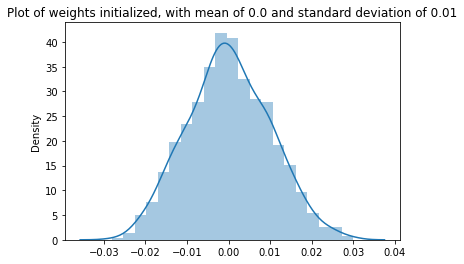

In [13]:
# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

In [14]:
def initialize_bias(shape, name=None, dtype=float):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

C:\Users\NgocBaoNGUYEN\.conda\envs\hddl\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01')

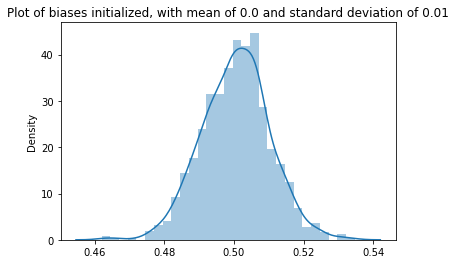

In [15]:
# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [16]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    return siamese_net

In [17]:
model = get_siamese_model((105, 105, 1))
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         38947648    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]        

### Optimizing function and loss function
The training was initially done using Stochastic gradient descent(as described in the paper) with a learning rate 0.0005(choosen randomly between 0.01 and 0.00001) initially, due to which the convergence of model was very slow, after 3000 iterations the validation decreased from .47 to .43, where when the training was done using Adam's algorithm to optimize the training process even though with a smaller learning rate of 0.00006, the decrease in the validation loss was much faster as compared to simple Stochastic Gradient Descent.



In [18]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Image Verification and Recognition



<img src="https://image.ibb.co/k3P0hJ/pixel_comparison.png" style="width:380px;height:150px;"></img>
<caption><center> <u> <font color='black'> **Figure 4**</font> </u></center></caption>
    
    





<img src="https://cdn-images-1.medium.com/max/800/1*wh1N-kogDMaZYS17lqyqeQ.jpeg"></img>
<caption><center> <u> <font color='black'> **Figure 5**</font> </u></center></caption>

## Dataset

<img src="https://cdn-images-1.medium.com/max/1600/1*fRd4Sc6cT0_KFm6IhB3Bqw.png"></img>
<caption><center> <u> <font color='black'> **Figure 6**</font> </u></center></caption>

To demonstrate few shot [Omniglot dataset](https://github.com/brendenlake/omniglot) is used, Omniglot of Lake et al. is a MNIST-like scribbles dataset with 1623 characters with 20 examples each. The large number of classes (characters) with relatively few data per class (20), makes this an ideal data set for testing few-shot classification.

The figures below show few of the samples from the dataset.

In [19]:
def plot_images(path):
    """
        Plot all 20 samples of a particular character of a language
    """
    f, axarr = plt.subplots(5,4, figsize=(10,10))
    images_list = []
    for image in os.listdir(path):
        image_path = os.path.join(path, image)
        img = cv2.imread(image_path)
        images_list.append(img)
    for i in range(5):
        for j in range(4):
            axarr[i,j].imshow(images_list.pop())

Arcadian language, 20 samples of the third character.


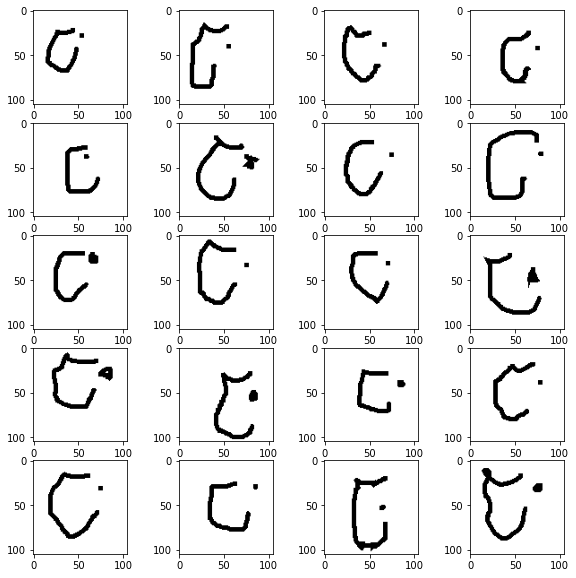

In [20]:
plot_images(os.path.join(data_path, 'images_background/Arcadian/character03/'))
print("Arcadian language, 20 samples of the third character.")

Korean language, 20 samples of the seventh character.


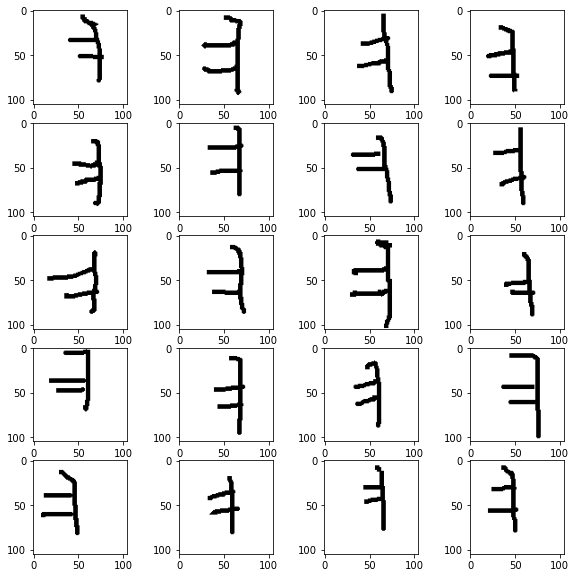

In [21]:
plot_images(os.path.join(data_path, 'images_background/Korean/character07/'))
print("Korean language, 20 samples of the seventh character.")

In [22]:
from load_data import *

loading alphabet: Alphabet_of_the_Magi
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Arcadian
loading alphabet: Armenian
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Balinese
loading alphabet: Bengali
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Braille
loading alphabet: Burmese_(Myanmar)
loading alphabet: Cyrillic
loading alphabet: Early_Aramaic
loading alphabet: Futurama
loading alphabet: Grantha
loading alphabet: Greek
loading alphabet: Gujarati
loading alphabet: Hebrew
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Japanese_(hiragana)
loading alphabet: Japanese_(katakana)
loading alphabet: Korean
loading alphabet: Latin
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: N_Ko
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Sanskrit
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Tagalog
loading alphabet: Tifinagh
loa

In [23]:
with open(os.path.join(data_path, "train.pickle"), "rb") as f:
    (X, classes) = pickle.load(f)

with open(os.path.join(data_path, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(classes.keys()))
print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Training alphabets: 

['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh']
Validation alphabets:

['Angelic', 'Atemayar_Qelisayer', 'Atlantean', 'Aurek-Besh', 'Avesta', 'Ge_ez', 'Glagolitic', 'Gurmukhi', 'Kannada', 'Keble', 'Malayalam', 'Manipuri', 'Mongolian', 'Old_Church_Slavonic_(Cyrillic)', 'Oriya', 'Sylheti', 'Syriac_(Serto)', 'Tengwar', 'Tibetan', 'ULOG']


### Training pipeline

In [24]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape

        #randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=False)
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size))
    

loader = Siamese_Loader(data_path)

loading data from data/train.pickle
loading data from data/val.pickle


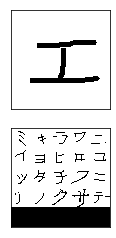

In [25]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

pairs, targets = loader.make_oneshot_task(20,"train","Japanese_(katakana)")
plot_oneshot_task(pairs)

<font color=red> This training process only take the best validation accuracy model throughout the whole training.
   
Observation: we did try training on both CPU and GPU. The estimated time on CPU was about 2 days while it was only several hours on GPU.

In [26]:
weights_path_2 = os.path.join(data_path, "model_weights.h5")
evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 20 # interval for printing loss (iterations)
batch_size = 32
n_iter = 20000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=model.train_on_batch(inputs,targets)
    print("\n ------------- \n")
    print("Loss: {0}".format(loss)) 
    if i % evaluate_every == 0:
        print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
        val_acc = loader.test_oneshot(model,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            print("Saving weights to: {0} \n".format(weights_path_2))
            model.save_weights(weights_path_2)
            best=val_acc
    
    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))

        

model.load_weights(weights_path_2)

Starting training process!
-------------------------------------


 ------------- 

Loss: 4.518637657165527

 ------------- 

Loss: 4.461789608001709

 ------------- 

Loss: 4.438719749450684

 ------------- 

Loss: 4.425201416015625

 ------------- 

Loss: 4.4226484298706055

 ------------- 

Loss: 4.392215251922607

 ------------- 

Loss: 4.364381790161133

 ------------- 

Loss: 4.34921932220459

 ------------- 

Loss: 4.3078293800354

 ------------- 

Loss: 4.305932998657227
Time for 10 iterations: 19.183072328567505
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 27.6% 20 way one-shot learning accuracy 

Current best: 27.6, previous best: -1
Saving weights to: data/model_weights.h5 


 ------------- 

Loss: 4.299229621887207

 ------------- 

Loss: 4.2485456466674805

 ------------- 

Loss: 4.234935760498047

 ------------- 

Loss: 4.209624290466309

 ------------- 

Loss: 4.198436737060547

 ------------- 

Loss: 4.158276081085205

 ---------


 ------------- 

Loss: 2.7460601329803467

 ------------- 

Loss: 3.0264205932617188
Time for 130 iterations: 135.61923718452454
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 17.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 2.7951507568359375

 ------------- 

Loss: 2.9007222652435303

 ------------- 

Loss: 2.9281065464019775

 ------------- 

Loss: 2.703934907913208

 ------------- 

Loss: 2.7347755432128906

 ------------- 

Loss: 2.8584718704223633

 ------------- 

Loss: 2.787841796875

 ------------- 

Loss: 2.786059856414795

 ------------- 

Loss: 2.8570284843444824

 ------------- 

Loss: 2.856609582901001
Time for 140 iterations: 145.19238233566284
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 36.0% 20 way one-shot learning accuracy 

Current best: 36.0, previous best: 30.0
Saving weights to: data/model_weights.h5 

iteration 140, training loss: 2.86,

 ------------- 

Loss: 2.86

Got an average of 31.2% 20 way one-shot learning accuracy 

iteration 260, training loss: 2.01,

 ------------- 

Loss: 2.070403575897217

 ------------- 

Loss: 2.164267063140869

 ------------- 

Loss: 2.024385452270508

 ------------- 

Loss: 2.1283016204833984

 ------------- 

Loss: 2.159175157546997

 ------------- 

Loss: 2.0254900455474854

 ------------- 

Loss: 2.0416958332061768

 ------------- 

Loss: 2.049748420715332

 ------------- 

Loss: 2.15732741355896

 ------------- 

Loss: 1.9080675840377808
Time for 270 iterations: 267.4559075832367
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 26.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 2.011838436126709

 ------------- 

Loss: 1.9112236499786377

 ------------- 

Loss: 2.036672592163086

 ------------- 

Loss: 2.146693229675293

 ------------- 

Loss: 2.1071813106536865

 ------------- 

Loss: 2.2264561653137207

 ------------- 

Loss: 2.0483105182647705

 ----------


 ------------- 

Loss: 1.672898530960083

 ------------- 

Loss: 1.6010478734970093

 ------------- 

Loss: 1.67305588722229

 ------------- 

Loss: 1.72817862033844

 ------------- 

Loss: 1.7324013710021973

 ------------- 

Loss: 1.6007740497589111

 ------------- 

Loss: 1.7043439149856567
Time for 400 iterations: 386.23789501190186
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 42.4% 20 way one-shot learning accuracy 

Current best: 42.4, previous best: 39.6
Saving weights to: data/model_weights.h5 

iteration 400, training loss: 1.70,

 ------------- 

Loss: 1.5941566228866577

 ------------- 

Loss: 1.5899615287780762

 ------------- 

Loss: 1.6953825950622559

 ------------- 

Loss: 1.8925583362579346

 ------------- 

Loss: 1.5847840309143066

 ------------- 

Loss: 1.5919585227966309

 ------------- 

Loss: 1.792067050933838

 ------------- 

Loss: 1.6946208477020264

 ------------- 

Loss: 1.6843554973602295

 ------------- 

Loss: 1.6

Got an average of 42.4% 20 way one-shot learning accuracy 

iteration 520, training loss: 1.55,

 ------------- 

Loss: 1.4969017505645752

 ------------- 

Loss: 1.4964104890823364

 ------------- 

Loss: 1.4970512390136719

 ------------- 

Loss: 1.436383605003357

 ------------- 

Loss: 1.6716238260269165

 ------------- 

Loss: 1.3608596324920654

 ------------- 

Loss: 1.449878215789795

 ------------- 

Loss: 1.504635214805603

 ------------- 

Loss: 1.4371222257614136

 ------------- 

Loss: 1.4346362352371216
Time for 530 iterations: 506.8620455265045
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 46.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 1.4537417888641357

 ------------- 

Loss: 1.3449410200119019

 ------------- 

Loss: 1.4137393236160278

 ------------- 

Loss: 1.428999423980713

 ------------- 

Loss: 1.4121575355529785

 ------------- 

Loss: 1.4884545803070068

 ------------- 

Loss: 1.564162015914917

 -----

Got an average of 49.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 1.2741036415100098

 ------------- 

Loss: 1.3005645275115967

 ------------- 

Loss: 1.271095633506775

 ------------- 

Loss: 1.3297793865203857

 ------------- 

Loss: 1.2284013032913208

 ------------- 

Loss: 1.1712119579315186

 ------------- 

Loss: 1.3186087608337402

 ------------- 

Loss: 1.3235126733779907

 ------------- 

Loss: 1.2394641637802124

 ------------- 

Loss: 1.2364252805709839
Time for 660 iterations: 625.7959430217743
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 43.6% 20 way one-shot learning accuracy 

iteration 660, training loss: 1.24,

 ------------- 

Loss: 1.1984258890151978

 ------------- 

Loss: 1.2551827430725098

 ------------- 

Loss: 1.1410257816314697

 ------------- 

Loss: 1.2047436237335205

 ------------- 

Loss: 1.2425031661987305

 ------------- 

Loss: 1.1944007873535156

 ------------- 

Loss: 1.3005138635635376

 -


 ------------- 

Loss: 1.1490991115570068

 ------------- 

Loss: 1.2477662563323975

 ------------- 

Loss: 1.147331714630127

 ------------- 

Loss: 1.1952226161956787

 ------------- 

Loss: 1.079133152961731

 ------------- 

Loss: 1.0838031768798828

 ------------- 

Loss: 1.0694663524627686

 ------------- 

Loss: 1.1752201318740845

 ------------- 

Loss: 1.223628282546997
Time for 790 iterations: 744.0445513725281
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 48.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 1.1254425048828125

 ------------- 

Loss: 1.0294371843338013

 ------------- 

Loss: 1.1009902954101562

 ------------- 

Loss: 1.2469996213912964

 ------------- 

Loss: 1.0718857049942017

 ------------- 

Loss: 1.0802254676818848

 ------------- 

Loss: 1.1838165521621704

 ------------- 

Loss: 1.4211890697479248

 ------------- 

Loss: 1.22178316116333

 ------------- 

Loss: 1.2460418939590454
Time for 800 iter


 ------------- 

Loss: 0.9902477860450745

 ------------- 

Loss: 1.0657963752746582

 ------------- 

Loss: 1.103182077407837

 ------------- 

Loss: 0.9456382393836975
Time for 920 iterations: 861.0028095245361
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 64.8% 20 way one-shot learning accuracy 

Current best: 64.8, previous best: 56.8
Saving weights to: data/model_weights.h5 

iteration 920, training loss: 0.95,

 ------------- 

Loss: 1.032457709312439

 ------------- 

Loss: 1.1406679153442383

 ------------- 

Loss: 1.0474002361297607

 ------------- 

Loss: 1.277735710144043

 ------------- 

Loss: 1.0249500274658203

 ------------- 

Loss: 0.9698227047920227

 ------------- 

Loss: 1.1268798112869263

 ------------- 

Loss: 1.0877330303192139

 ------------- 

Loss: 1.0435067415237427

 ------------- 

Loss: 1.1637012958526611
Time for 930 iterations: 870.4575734138489
Evaluating model on 250 random 20 way one-shot learning tasks ... 




 ------------- 

Loss: 0.9360467195510864

 ------------- 

Loss: 0.8933005332946777
Time for 1050 iterations: 979.4452505111694
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 64.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.8690614700317383

 ------------- 

Loss: 0.8649224638938904

 ------------- 

Loss: 0.9597655534744263

 ------------- 

Loss: 0.8499133586883545

 ------------- 

Loss: 0.7776262164115906

 ------------- 

Loss: 0.9285860657691956

 ------------- 

Loss: 1.092511534690857

 ------------- 

Loss: 0.9574971199035645

 ------------- 

Loss: 0.9364262819290161

 ------------- 

Loss: 0.8413143754005432
Time for 1060 iterations: 988.3900380134583
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 60.0% 20 way one-shot learning accuracy 

iteration 1060, training loss: 0.84,

 ------------- 

Loss: 1.058910608291626

 ------------- 

Loss: 0.8726958632469177

 ------------- 

L

Got an average of 49.2% 20 way one-shot learning accuracy 

iteration 1180, training loss: 0.93,

 ------------- 

Loss: 0.8236172199249268

 ------------- 

Loss: 1.1051249504089355

 ------------- 

Loss: 0.8363633751869202

 ------------- 

Loss: 0.905824601650238

 ------------- 

Loss: 0.7901573181152344

 ------------- 

Loss: 0.8468025922775269

 ------------- 

Loss: 0.8016288876533508

 ------------- 

Loss: 0.9066306352615356

 ------------- 

Loss: 0.8050736784934998

 ------------- 

Loss: 1.0024698972702026
Time for 1190 iterations: 1105.0497608184814
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 64.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.8874260187149048

 ------------- 

Loss: 0.8873414993286133

 ------------- 

Loss: 0.9057060480117798

 ------------- 

Loss: 0.8180649280548096

 ------------- 

Loss: 0.8016253113746643

 ------------- 

Loss: 0.9132971167564392

 ------------- 

Loss: 0.9352372288703918



 ------------- 

Loss: 0.7704659700393677

 ------------- 

Loss: 0.8941507935523987

 ------------- 

Loss: 0.7842088937759399

 ------------- 

Loss: 0.6906018257141113

 ------------- 

Loss: 1.0301451683044434

 ------------- 

Loss: 0.9142526388168335

 ------------- 

Loss: 0.7788959741592407

 ------------- 

Loss: 0.9459731578826904
Time for 1320 iterations: 1222.5973756313324
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 61.2% 20 way one-shot learning accuracy 

iteration 1320, training loss: 0.95,

 ------------- 

Loss: 0.8377223014831543

 ------------- 

Loss: 0.8921114206314087

 ------------- 

Loss: 0.8184571266174316

 ------------- 

Loss: 0.8436123132705688

 ------------- 

Loss: 0.8736027479171753

 ------------- 

Loss: 0.8613518476486206

 ------------- 

Loss: 0.7992119193077087

 ------------- 

Loss: 0.8350008726119995

 ------------- 

Loss: 0.7561792731285095

 ------------- 

Loss: 0.7774518728256226
Time for 1330 it


 ------------- 

Loss: 0.7008929252624512

 ------------- 

Loss: 0.7373648881912231

 ------------- 

Loss: 0.7337051033973694

 ------------- 

Loss: 0.8033092021942139

 ------------- 

Loss: 0.7265082597732544

 ------------- 

Loss: 0.7621814608573914

 ------------- 

Loss: 0.753169059753418
Time for 1450 iterations: 1340.0082294940948
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 66.0% 20 way one-shot learning accuracy 

Current best: 66.0, previous best: 65.2
Saving weights to: data/model_weights.h5 


 ------------- 

Loss: 0.7251490354537964

 ------------- 

Loss: 0.7396116256713867

 ------------- 

Loss: 0.7166483402252197

 ------------- 

Loss: 0.6975574493408203

 ------------- 

Loss: 0.740511953830719

 ------------- 

Loss: 0.8813159465789795

 ------------- 

Loss: 0.867677628993988

 ------------- 

Loss: 0.7853020429611206

 ------------- 

Loss: 0.9374648332595825

 ------------- 

Loss: 0.6823522448539734
Time for 1460 it


 ------------- 

Loss: 0.7377597689628601

 ------------- 

Loss: 0.666248083114624

 ------------- 

Loss: 0.6644672155380249

 ------------- 

Loss: 0.7463020086288452

 ------------- 

Loss: 1.190388560295105

 ------------- 

Loss: 0.7027274966239929

 ------------- 

Loss: 0.6275060176849365
Time for 1580 iterations: 1457.684893131256
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 64.4% 20 way one-shot learning accuracy 

iteration 1580, training loss: 0.63,

 ------------- 

Loss: 0.7564035654067993

 ------------- 

Loss: 0.7118048667907715

 ------------- 

Loss: 0.7162186503410339

 ------------- 

Loss: 0.7143654823303223

 ------------- 

Loss: 1.0095365047454834

 ------------- 

Loss: 0.7485837936401367

 ------------- 

Loss: 0.6373976469039917

 ------------- 

Loss: 0.6425934433937073

 ------------- 

Loss: 0.9426676630973816

 ------------- 

Loss: 0.7395936846733093
Time for 1590 iterations: 1466.662270307541
Evaluating model o


 ------------- 

Loss: 0.7141684293746948

 ------------- 

Loss: 0.7290923595428467

 ------------- 

Loss: 0.5901324152946472

 ------------- 

Loss: 0.7713541388511658

 ------------- 

Loss: 0.7459442019462585

 ------------- 

Loss: 0.8372764587402344
Time for 1710 iterations: 1575.6004717350006
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 62.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.633034348487854

 ------------- 

Loss: 0.616885781288147

 ------------- 

Loss: 0.6649296283721924

 ------------- 

Loss: 0.5873349905014038

 ------------- 

Loss: 0.7216230630874634

 ------------- 

Loss: 0.6554958820343018

 ------------- 

Loss: 0.8280194401741028

 ------------- 

Loss: 0.5788774490356445

 ------------- 

Loss: 0.6898499727249146

 ------------- 

Loss: 0.6769382357597351
Time for 1720 iterations: 1584.5916283130646
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 68.8% 20 w


 ------------- 

Loss: 0.7591906785964966

 ------------- 

Loss: 0.804099440574646

 ------------- 

Loss: 0.7223683595657349

 ------------- 

Loss: 0.6514177322387695

 ------------- 

Loss: 0.7351764440536499

 ------------- 

Loss: 0.5886773467063904

 ------------- 

Loss: 0.6005541086196899

 ------------- 

Loss: 0.5544276237487793
Time for 1840 iterations: 1694.8602991104126
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 64.8% 20 way one-shot learning accuracy 

iteration 1840, training loss: 0.55,

 ------------- 

Loss: 0.6527581214904785

 ------------- 

Loss: 0.6948392391204834

 ------------- 

Loss: 0.6169301271438599

 ------------- 

Loss: 0.7983705997467041

 ------------- 

Loss: 0.5856523513793945

 ------------- 

Loss: 0.6535576581954956

 ------------- 

Loss: 0.5797915458679199

 ------------- 

Loss: 0.8342698812484741

 ------------- 

Loss: 0.6525644063949585

 ------------- 

Loss: 0.6337900161743164
Time for 1850 ite


 ------------- 

Loss: 0.6487470865249634

 ------------- 

Loss: 0.5733212232589722

 ------------- 

Loss: 0.5482404828071594

 ------------- 

Loss: 0.5290385484695435

 ------------- 

Loss: 0.7723498344421387

 ------------- 

Loss: 0.6446065902709961

 ------------- 

Loss: 0.5457005500793457
Time for 1970 iterations: 1811.9137217998505
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 68.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.6230834126472473

 ------------- 

Loss: 0.49453139305114746

 ------------- 

Loss: 0.5822926759719849

 ------------- 

Loss: 0.6206099987030029

 ------------- 

Loss: 0.5464633703231812

 ------------- 

Loss: 0.6542282104492188

 ------------- 

Loss: 0.6264752745628357

 ------------- 

Loss: 0.5327414274215698

 ------------- 

Loss: 0.5385468006134033

 ------------- 

Loss: 0.5714303255081177
Time for 1980 iterations: 1821.0594763755798
Evaluating model on 250 random 20 way one-shot lea

Loss: 0.6892361640930176

 ------------- 

Loss: 0.6876925230026245

 ------------- 

Loss: 0.5541619658470154

 ------------- 

Loss: 0.5554958581924438

 ------------- 

Loss: 0.6234243512153625
Time for 2100 iterations: 1929.684510231018
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 64.4% 20 way one-shot learning accuracy 

iteration 2100, training loss: 0.62,

 ------------- 

Loss: 0.6800612211227417

 ------------- 

Loss: 0.604874849319458

 ------------- 

Loss: 0.5731414556503296

 ------------- 

Loss: 0.635992169380188

 ------------- 

Loss: 0.5129792094230652

 ------------- 

Loss: 0.6070252060890198

 ------------- 

Loss: 0.599126935005188

 ------------- 

Loss: 0.5927923917770386

 ------------- 

Loss: 0.5055328011512756

 ------------- 

Loss: 0.5821069478988647
Time for 2110 iterations: 1938.9457046985626
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 62.8% 20 way one-shot learning accur


 ------------- 

Loss: 0.5843154191970825
Time for 2230 iterations: 2048.014814853668
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 64.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.5326977968215942

 ------------- 

Loss: 0.6074376702308655

 ------------- 

Loss: 0.5359523296356201

 ------------- 

Loss: 0.7295968532562256

 ------------- 

Loss: 0.5415732264518738

 ------------- 

Loss: 0.5857827663421631

 ------------- 

Loss: 0.58747398853302

 ------------- 

Loss: 0.5145377516746521

 ------------- 

Loss: 0.5216941237449646

 ------------- 

Loss: 0.5852000713348389
Time for 2240 iterations: 2056.9757828712463
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 66.8% 20 way one-shot learning accuracy 

iteration 2240, training loss: 0.59,

 ------------- 

Loss: 0.5869591236114502

 ------------- 

Loss: 0.5560521483421326

 ------------- 

Loss: 0.4755645990371704

 ------------- 



Got an average of 65.6% 20 way one-shot learning accuracy 

iteration 2360, training loss: 0.50,

 ------------- 

Loss: 0.47287583351135254

 ------------- 

Loss: 0.5384472608566284

 ------------- 

Loss: 0.49485403299331665

 ------------- 

Loss: 0.4385497570037842

 ------------- 

Loss: 0.5420724749565125

 ------------- 

Loss: 0.7034518718719482

 ------------- 

Loss: 0.4798939824104309

 ------------- 

Loss: 0.48963862657546997

 ------------- 

Loss: 0.7018356919288635

 ------------- 

Loss: 0.4917396605014801
Time for 2370 iterations: 2173.5869925022125
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 71.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.6290460824966431

 ------------- 

Loss: 0.601393461227417

 ------------- 

Loss: 0.6346977949142456

 ------------- 

Loss: 0.4971919655799866

 ------------- 

Loss: 0.6719344854354858

 ------------- 

Loss: 0.4684098958969116

 ------------- 

Loss: 0.62453258037567


 ------------- 

Loss: 0.5512791872024536

 ------------- 

Loss: 0.5130233764648438

 ------------- 

Loss: 0.44539138674736023

 ------------- 

Loss: 0.5179044008255005

 ------------- 

Loss: 0.46072933077812195

 ------------- 

Loss: 0.5215734839439392

 ------------- 

Loss: 0.6338450312614441

 ------------- 

Loss: 0.6456225514411926

 ------------- 

Loss: 0.4676046371459961

 ------------- 

Loss: 0.45675164461135864
Time for 2500 iterations: 2290.705789089203
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.0% 20 way one-shot learning accuracy 

iteration 2500, training loss: 0.46,

 ------------- 

Loss: 0.5812018513679504

 ------------- 

Loss: 0.5427988767623901

 ------------- 

Loss: 0.5155228972434998

 ------------- 

Loss: 0.5558943748474121

 ------------- 

Loss: 0.41124847531318665

 ------------- 

Loss: 0.44812071323394775

 ------------- 

Loss: 0.5893892049789429

 ------------- 

Loss: 0.485203355550766

 -----------


 ------------- 

Loss: 0.3779565095901489

 ------------- 

Loss: 0.4612219035625458

 ------------- 

Loss: 0.39604902267456055

 ------------- 

Loss: 0.4792856276035309

 ------------- 

Loss: 0.4085896909236908

 ------------- 

Loss: 0.4910695552825928

 ------------- 

Loss: 0.5953711271286011

 ------------- 

Loss: 0.4157617390155792
Time for 2630 iterations: 2407.227570772171
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 62.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.5961717367172241

 ------------- 

Loss: 0.5644444227218628

 ------------- 

Loss: 0.5419352650642395

 ------------- 

Loss: 0.72908616065979

 ------------- 

Loss: 0.49636781215667725

 ------------- 

Loss: 0.474612295627594

 ------------- 

Loss: 0.6384142637252808

 ------------- 

Loss: 0.5880190134048462

 ------------- 

Loss: 0.4178468585014343

 ------------- 

Loss: 0.5223519802093506
Time for 2640 iterations: 2416.1969039440155
Evaluating

Loss: 0.4552972912788391

 ------------- 

Loss: 0.4461793601512909

 ------------- 

Loss: 0.5947054624557495

 ------------- 

Loss: 0.45213186740875244

 ------------- 

Loss: 0.49683138728141785

 ------------- 

Loss: 0.42116475105285645
Time for 2760 iterations: 2523.7668640613556
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 64.4% 20 way one-shot learning accuracy 

iteration 2760, training loss: 0.42,

 ------------- 

Loss: 0.5197218656539917

 ------------- 

Loss: 0.5322747826576233

 ------------- 

Loss: 0.4992830753326416

 ------------- 

Loss: 0.45443981885910034

 ------------- 

Loss: 0.5273841619491577

 ------------- 

Loss: 0.4890175759792328

 ------------- 

Loss: 0.4373420476913452

 ------------- 

Loss: 0.6410223245620728

 ------------- 

Loss: 0.37740519642829895

 ------------- 

Loss: 0.5041956305503845
Time for 2770 iterations: 2532.7424149513245
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Go


 ------------- 

Loss: 0.4321690797805786

 ------------- 

Loss: 0.5029096007347107

 ------------- 

Loss: 0.4284709095954895

 ------------- 

Loss: 0.4263719916343689

 ------------- 

Loss: 0.508455753326416
Time for 2890 iterations: 2640.7908260822296
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 64.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.596459150314331

 ------------- 

Loss: 0.614843487739563

 ------------- 

Loss: 0.5190060138702393

 ------------- 

Loss: 0.4456974267959595

 ------------- 

Loss: 0.5889597535133362

 ------------- 

Loss: 0.43921971321105957

 ------------- 

Loss: 0.5441284775733948

 ------------- 

Loss: 0.387539267539978

 ------------- 

Loss: 0.4578598737716675

 ------------- 

Loss: 0.49903586506843567
Time for 2900 iterations: 2649.7569024562836
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.0% 20 way one-shot learning accuracy 

iteration 2


 ------------- 

Loss: 0.41815078258514404

 ------------- 

Loss: 0.3966250717639923
Time for 3020 iterations: 2757.3946101665497
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 67.2% 20 way one-shot learning accuracy 

iteration 3020, training loss: 0.40,

 ------------- 

Loss: 0.5696350336074829

 ------------- 

Loss: 0.4021846055984497

 ------------- 

Loss: 0.4377898573875427

 ------------- 

Loss: 0.4468967914581299

 ------------- 

Loss: 0.44446733593940735

 ------------- 

Loss: 0.49011239409446716

 ------------- 

Loss: 0.43581557273864746

 ------------- 

Loss: 0.5336439609527588

 ------------- 

Loss: 0.3959101438522339

 ------------- 

Loss: 0.47575294971466064
Time for 3030 iterations: 2766.3511216640472
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.4700474143028259

 ------------- 

Loss: 0.3848651647567749

 --------

Got an average of 72.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.42935436964035034

 ------------- 

Loss: 0.49646592140197754

 ------------- 

Loss: 0.40009254217147827

 ------------- 

Loss: 0.437186598777771

 ------------- 

Loss: 0.3958062529563904

 ------------- 

Loss: 0.3963898718357086

 ------------- 

Loss: 0.4262637495994568

 ------------- 

Loss: 0.42099156975746155

 ------------- 

Loss: 0.4876573085784912

 ------------- 

Loss: 0.4644365906715393
Time for 3160 iterations: 2882.9861528873444
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.0% 20 way one-shot learning accuracy 

iteration 3160, training loss: 0.46,

 ------------- 

Loss: 0.5151269435882568

 ------------- 

Loss: 0.37636226415634155

 ------------- 

Loss: 0.461889386177063

 ------------- 

Loss: 0.4184854328632355

 ------------- 

Loss: 0.4239497184753418

 ------------- 

Loss: 0.4139118790626526

 ------------- 

Loss: 0.5325949788093


 ------------- 

Loss: 0.44374793767929077

 ------------- 

Loss: 0.39581355452537537

 ------------- 

Loss: 0.43752866983413696

 ------------- 

Loss: 0.35297420620918274

 ------------- 

Loss: 0.3731932044029236

 ------------- 

Loss: 0.36869072914123535

 ------------- 

Loss: 0.36009547114372253

 ------------- 

Loss: 0.45356690883636475
Time for 3290 iterations: 2999.742125749588
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.4284822940826416

 ------------- 

Loss: 0.4016141891479492

 ------------- 

Loss: 0.42538848519325256

 ------------- 

Loss: 0.4105600118637085

 ------------- 

Loss: 0.44314253330230713

 ------------- 

Loss: 0.3575435280799866

 ------------- 

Loss: 0.45840662717819214

 ------------- 

Loss: 0.3806001842021942

 ------------- 

Loss: 0.45396187901496887

 ------------- 

Loss: 0.41174226999282837
Time for 3300 iterations: 3008.73560142517


 ------------- 

Loss: 0.43379858136177063

 ------------- 

Loss: 0.4573935270309448

 ------------- 

Loss: 0.5160953998565674

 ------------- 

Loss: 0.437757670879364
Time for 3420 iterations: 3116.631950378418
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 71.6% 20 way one-shot learning accuracy 

iteration 3420, training loss: 0.44,

 ------------- 

Loss: 0.6533081531524658

 ------------- 

Loss: 0.4201620817184448

 ------------- 

Loss: 0.4590112566947937

 ------------- 

Loss: 0.5415157079696655

 ------------- 

Loss: 0.42264315485954285

 ------------- 

Loss: 0.4408589005470276

 ------------- 

Loss: 0.39477962255477905

 ------------- 

Loss: 0.3946978449821472

 ------------- 

Loss: 0.4185355603694916

 ------------- 

Loss: 0.45990341901779175
Time for 3430 iterations: 3125.6467814445496
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.4% 20 way one-shot learning accuracy 


 -----------


 ------------- 

Loss: 0.5442413687705994

 ------------- 

Loss: 0.5658209919929504

 ------------- 

Loss: 0.37558430433273315
Time for 3550 iterations: 3234.1213884353638
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 68.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.40964990854263306

 ------------- 

Loss: 0.29985201358795166

 ------------- 

Loss: 0.4028795063495636

 ------------- 

Loss: 0.3485209345817566

 ------------- 

Loss: 0.4344591498374939

 ------------- 

Loss: 0.3571622669696808

 ------------- 

Loss: 0.4705609977245331

 ------------- 

Loss: 0.4029628336429596

 ------------- 

Loss: 0.33597975969314575

 ------------- 

Loss: 0.48130977153778076
Time for 3560 iterations: 3243.1092772483826
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 66.8% 20 way one-shot learning accuracy 

iteration 3560, training loss: 0.48,

 ------------- 

Loss: 0.4218035638332367

 --------

Got an average of 70.4% 20 way one-shot learning accuracy 

iteration 3680, training loss: 0.35,

 ------------- 

Loss: 0.3249359726905823

 ------------- 

Loss: 0.46775394678115845

 ------------- 

Loss: 0.33653172850608826

 ------------- 

Loss: 0.3967275023460388

 ------------- 

Loss: 0.4850776791572571

 ------------- 

Loss: 0.43496227264404297

 ------------- 

Loss: 0.365980327129364

 ------------- 

Loss: 0.37969863414764404

 ------------- 

Loss: 0.28916338086128235

 ------------- 

Loss: 0.41783586144447327
Time for 3690 iterations: 3359.9785318374634
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.34184032678604126

 ------------- 

Loss: 0.4209824502468109

 ------------- 

Loss: 0.3567844033241272

 ------------- 

Loss: 0.30684012174606323

 ------------- 

Loss: 0.413444459438324

 ------------- 

Loss: 0.551130473613739

 ------------- 

Loss: 0.41403502225

Loss: 0.3900178074836731

 ------------- 

Loss: 0.38052356243133545

 ------------- 

Loss: 0.31275296211242676

 ------------- 

Loss: 0.34858235716819763

 ------------- 

Loss: 0.3704622685909271

 ------------- 

Loss: 0.4339837431907654

 ------------- 

Loss: 0.34144726395606995

 ------------- 

Loss: 0.37951570749282837

 ------------- 

Loss: 0.33037251234054565

 ------------- 

Loss: 0.5300388932228088
Time for 3820 iterations: 3476.939954996109
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.2% 20 way one-shot learning accuracy 

iteration 3820, training loss: 0.53,

 ------------- 

Loss: 0.33713871240615845

 ------------- 

Loss: 0.36931276321411133

 ------------- 

Loss: 0.3813459873199463

 ------------- 

Loss: 0.344032883644104

 ------------- 

Loss: 0.3876808285713196

 ------------- 

Loss: 0.3449559807777405

 ------------- 

Loss: 0.439422070980072

 ------------- 

Loss: 0.44757771492004395

 ------------- 

Loss: 0.49

Loss: 0.42092061042785645

 ------------- 

Loss: 0.4798913896083832

 ------------- 

Loss: 0.43451064825057983

 ------------- 

Loss: 0.4576798379421234

 ------------- 

Loss: 0.44074949622154236

 ------------- 

Loss: 0.30079689621925354

 ------------- 

Loss: 0.3965339958667755

 ------------- 

Loss: 0.39750468730926514

 ------------- 

Loss: 0.3448791205883026
Time for 3950 iterations: 3594.027621984482
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 66.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3683159351348877

 ------------- 

Loss: 0.33640575408935547

 ------------- 

Loss: 0.3960033655166626

 ------------- 

Loss: 0.3493404984474182

 ------------- 

Loss: 0.3874562978744507

 ------------- 

Loss: 0.31720250844955444

 ------------- 

Loss: 0.39597415924072266

 ------------- 

Loss: 0.5127750039100647

 ------------- 

Loss: 0.3251839876174927

 ------------- 

Loss: 0.31089648604393005
Time for 3960 iterat


 ------------- 

Loss: 0.3064254820346832

 ------------- 

Loss: 0.4114952087402344

 ------------- 

Loss: 0.46260708570480347

 ------------- 

Loss: 0.33528226613998413

 ------------- 

Loss: 0.3674071431159973

 ------------- 

Loss: 0.38421785831451416
Time for 4080 iterations: 3710.7587792873383
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.8% 20 way one-shot learning accuracy 

Current best: 76.8, previous best: 76.8
Saving weights to: data/model_weights.h5 

iteration 4080, training loss: 0.38,

 ------------- 

Loss: 0.3759511113166809

 ------------- 

Loss: 0.407480388879776

 ------------- 

Loss: 0.45781847834587097

 ------------- 

Loss: 0.46113401651382446

 ------------- 

Loss: 0.36626750230789185

 ------------- 

Loss: 0.39639586210250854

 ------------- 

Loss: 0.3491445779800415

 ------------- 

Loss: 0.3031412363052368

 ------------- 

Loss: 0.4594174325466156

 ------------- 

Loss: 0.3872973322868347
Time for 4090


 ------------- 

Loss: 0.31951335072517395

 ------------- 

Loss: 0.5693076848983765

 ------------- 

Loss: 0.5006760358810425

 ------------- 

Loss: 0.3391225039958954

 ------------- 

Loss: 0.41474199295043945
Time for 4210 iterations: 3827.852680206299
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 71.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.36740773916244507

 ------------- 

Loss: 0.3161831796169281

 ------------- 

Loss: 0.30931034684181213

 ------------- 

Loss: 0.47717997431755066

 ------------- 

Loss: 0.2997712194919586

 ------------- 

Loss: 0.36748188734054565

 ------------- 

Loss: 0.4231707453727722

 ------------- 

Loss: 0.375657320022583

 ------------- 

Loss: 0.32254818081855774

 ------------- 

Loss: 0.34787219762802124
Time for 4220 iterations: 3836.8228421211243
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.2% 20 way one-shot learning accuracy 

ite


 ------------- 

Loss: 0.29586899280548096

 ------------- 

Loss: 0.4245702624320984

 ------------- 

Loss: 0.3083533048629761

 ------------- 

Loss: 0.32738733291625977
Time for 4340 iterations: 3944.962186574936
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.4% 20 way one-shot learning accuracy 

iteration 4340, training loss: 0.33,

 ------------- 

Loss: 0.5226780772209167

 ------------- 

Loss: 0.3930182456970215

 ------------- 

Loss: 0.42364346981048584

 ------------- 

Loss: 0.298053503036499

 ------------- 

Loss: 0.34308677911758423

 ------------- 

Loss: 0.42638665437698364

 ------------- 

Loss: 0.4002714157104492

 ------------- 

Loss: 0.36781057715415955

 ------------- 

Loss: 0.4487159848213196

 ------------- 

Loss: 0.2882218360900879
Time for 4350 iterations: 3953.942190170288
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.0% 20 way one-shot learning accuracy 


 ----------


 ------------- 

Loss: 0.2596336305141449

 ------------- 

Loss: 0.31691303849220276
Time for 4470 iterations: 4061.5438816547394
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.28693100810050964

 ------------- 

Loss: 0.26154810190200806

 ------------- 

Loss: 0.4974663257598877

 ------------- 

Loss: 0.3102090060710907

 ------------- 

Loss: 0.3000560402870178

 ------------- 

Loss: 0.27106696367263794

 ------------- 

Loss: 0.3167375922203064

 ------------- 

Loss: 0.2774428427219391

 ------------- 

Loss: 0.3247973620891571

 ------------- 

Loss: 0.30454710125923157
Time for 4480 iterations: 4070.527103662491
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.2% 20 way one-shot learning accuracy 

iteration 4480, training loss: 0.30,

 ------------- 

Loss: 0.4272335171699524

 ------------- 

Loss: 0.451582133769989

 ----------

Got an average of 72.0% 20 way one-shot learning accuracy 

iteration 4600, training loss: 0.32,

 ------------- 

Loss: 0.29478469491004944

 ------------- 

Loss: 0.3301171660423279

 ------------- 

Loss: 0.35595351457595825

 ------------- 

Loss: 0.35585731267929077

 ------------- 

Loss: 0.35756710171699524

 ------------- 

Loss: 0.3407100737094879

 ------------- 

Loss: 0.38581687211990356

 ------------- 

Loss: 0.3666686415672302

 ------------- 

Loss: 0.418041855096817

 ------------- 

Loss: 0.29706645011901855
Time for 4610 iterations: 4187.091037988663
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 68.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.350236713886261

 ------------- 

Loss: 0.335985392332077

 ------------- 

Loss: 0.25410130620002747

 ------------- 

Loss: 0.3454662561416626

 ------------- 

Loss: 0.3348838686943054

 ------------- 

Loss: 0.40960493683815

 ------------- 

Loss: 0.312928974628448


 ------------- 

Loss: 0.36823081970214844

 ------------- 

Loss: 0.2455449253320694

 ------------- 

Loss: 0.28095054626464844

 ------------- 

Loss: 0.28966522216796875

 ------------- 

Loss: 0.4840027391910553

 ------------- 

Loss: 0.37866824865341187

 ------------- 

Loss: 0.40906500816345215

 ------------- 

Loss: 0.28202277421951294

 ------------- 

Loss: 0.36194539070129395
Time for 4740 iterations: 4303.633300542831
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.0% 20 way one-shot learning accuracy 

iteration 4740, training loss: 0.36,

 ------------- 

Loss: 0.3505546748638153

 ------------- 

Loss: 0.40909284353256226

 ------------- 

Loss: 0.27934542298316956

 ------------- 

Loss: 0.28576385974884033

 ------------- 

Loss: 0.3208419680595398

 ------------- 

Loss: 0.2863960564136505

 ------------- 

Loss: 0.45816171169281006

 ------------- 

Loss: 0.30529141426086426

 ------------- 

Loss: 0.4243331849575043

 ---


 ------------- 

Loss: 0.3312322497367859

 ------------- 

Loss: 0.3155258893966675

 ------------- 

Loss: 0.27169549465179443

 ------------- 

Loss: 0.30493271350860596

 ------------- 

Loss: 0.2396766096353531

 ------------- 

Loss: 0.3446391820907593
Time for 4870 iterations: 4420.200544118881
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.25757622718811035

 ------------- 

Loss: 0.2507759928703308

 ------------- 

Loss: 0.34780195355415344

 ------------- 

Loss: 0.33867573738098145

 ------------- 

Loss: 0.28904393315315247

 ------------- 

Loss: 0.2628844380378723

 ------------- 

Loss: 0.3558342456817627

 ------------- 

Loss: 0.285005122423172

 ------------- 

Loss: 0.2641856074333191

 ------------- 

Loss: 0.3744594156742096
Time for 4880 iterations: 4429.167618751526
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.6%


 ------------- 

Loss: 0.2578389644622803

 ------------- 

Loss: 0.31400519609451294
Time for 5000 iterations: 4536.826350927353
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.0% 20 way one-shot learning accuracy 

iteration 5000, training loss: 0.31,

 ------------- 

Loss: 0.3171933889389038

 ------------- 

Loss: 0.32306498289108276

 ------------- 

Loss: 0.32456672191619873

 ------------- 

Loss: 0.4582858085632324

 ------------- 

Loss: 0.32284021377563477

 ------------- 

Loss: 0.33741962909698486

 ------------- 

Loss: 0.296019971370697

 ------------- 

Loss: 0.3084079623222351

 ------------- 

Loss: 0.3271141052246094

 ------------- 

Loss: 0.4208289682865143
Time for 5010 iterations: 4545.790117263794
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.26867806911468506

 ------------- 

Loss: 0.3580910563468933

 ----------

Got an average of 70.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3071025013923645

 ------------- 

Loss: 0.2378150224685669

 ------------- 

Loss: 0.26475584506988525

 ------------- 

Loss: 0.37629860639572144

 ------------- 

Loss: 0.4663054943084717

 ------------- 

Loss: 0.35506266355514526

 ------------- 

Loss: 0.35320621728897095

 ------------- 

Loss: 0.3184628486633301

 ------------- 

Loss: 0.4336860775947571

 ------------- 

Loss: 0.3119546175003052
Time for 5140 iterations: 4662.342502355576
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.0% 20 way one-shot learning accuracy 

iteration 5140, training loss: 0.31,

 ------------- 

Loss: 0.24401970207691193

 ------------- 

Loss: 0.26509416103363037

 ------------- 

Loss: 0.2502972483634949

 ------------- 

Loss: 0.26283204555511475

 ------------- 

Loss: 0.26773375272750854

 ------------- 

Loss: 0.28578197956085205

 ------------- 

Loss: 0.47786107


 ------------- 

Loss: 0.3199176490306854

 ------------- 

Loss: 0.3561331331729889

 ------------- 

Loss: 0.32498878240585327

 ------------- 

Loss: 0.26763463020324707

 ------------- 

Loss: 0.3665042519569397

 ------------- 

Loss: 0.30442190170288086

 ------------- 

Loss: 0.2923525869846344

 ------------- 

Loss: 0.2976500988006592

 ------------- 

Loss: 0.2483820915222168
Time for 5270 iterations: 4779.3526446819305
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3693586587905884

 ------------- 

Loss: 0.3420438766479492

 ------------- 

Loss: 0.32285982370376587

 ------------- 

Loss: 0.28176093101501465

 ------------- 

Loss: 0.5608762502670288

 ------------- 

Loss: 0.34707939624786377

 ------------- 

Loss: 0.341207891702652

 ------------- 

Loss: 0.28503525257110596

 ------------- 

Loss: 0.29535990953445435

 ------------- 

Loss: 0.2510422468185425
Tim


 ------------- 

Loss: 0.30204272270202637

 ------------- 

Loss: 0.32008999586105347

 ------------- 

Loss: 0.357544481754303

 ------------- 

Loss: 0.34757259488105774

 ------------- 

Loss: 0.3322948217391968

 ------------- 

Loss: 0.3158835172653198
Time for 5400 iterations: 4895.941595315933
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.0% 20 way one-shot learning accuracy 

iteration 5400, training loss: 0.32,

 ------------- 

Loss: 0.2816923260688782

 ------------- 

Loss: 0.46217629313468933

 ------------- 

Loss: 0.30762332677841187

 ------------- 

Loss: 0.4408190846443176

 ------------- 

Loss: 0.43221986293792725

 ------------- 

Loss: 0.2591450810432434

 ------------- 

Loss: 0.26250138878822327

 ------------- 

Loss: 0.31801724433898926

 ------------- 

Loss: 0.2939942479133606

 ------------- 

Loss: 0.24288803339004517
Time for 5410 iterations: 4904.925446033478
Evaluating model on 250 random 20 way one-shot lear


 ------------- 

Loss: 0.5207630395889282

 ------------- 

Loss: 0.45249590277671814

 ------------- 

Loss: 0.3293461799621582

 ------------- 

Loss: 0.39202946424484253
Time for 5530 iterations: 5012.555898427963
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.24173492193222046

 ------------- 

Loss: 0.2675822675228119

 ------------- 

Loss: 0.23549076914787292

 ------------- 

Loss: 0.33060508966445923

 ------------- 

Loss: 0.2870534658432007

 ------------- 

Loss: 0.3459847569465637

 ------------- 

Loss: 0.25287044048309326

 ------------- 

Loss: 0.31050848960876465

 ------------- 

Loss: 0.29496118426322937

 ------------- 

Loss: 0.38228631019592285
Time for 5540 iterations: 5021.531814575195
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.8% 20 way one-shot learning accuracy 

iteration 5540, training loss: 0.38,

 ------


 ------------- 

Loss: 0.313637912273407
Time for 5660 iterations: 5129.122045278549
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.6% 20 way one-shot learning accuracy 

iteration 5660, training loss: 0.31,

 ------------- 

Loss: 0.23849213123321533

 ------------- 

Loss: 0.2997001111507416

 ------------- 

Loss: 0.39626628160476685

 ------------- 

Loss: 0.280448317527771

 ------------- 

Loss: 0.2662992477416992

 ------------- 

Loss: 0.3593633770942688

 ------------- 

Loss: 0.26079443097114563

 ------------- 

Loss: 0.31478023529052734

 ------------- 

Loss: 0.23261234164237976

 ------------- 

Loss: 0.36165809631347656
Time for 5670 iterations: 5138.087627410889
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 68.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.30247342586517334

 ------------- 

Loss: 0.2910047769546509

 ------------- 

Loss: 0.2963810861110687

 ----------

Got an average of 74.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.29762232303619385

 ------------- 

Loss: 0.30865663290023804

 ------------- 

Loss: 0.25860971212387085

 ------------- 

Loss: 0.2551501989364624

 ------------- 

Loss: 0.2914317548274994

 ------------- 

Loss: 0.21566390991210938

 ------------- 

Loss: 0.3659989535808563

 ------------- 

Loss: 0.2253742218017578

 ------------- 

Loss: 0.23539695143699646

 ------------- 

Loss: 0.2511333227157593
Time for 5800 iterations: 5254.660764694214
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.6% 20 way one-shot learning accuracy 

iteration 5800, training loss: 0.25,

 ------------- 

Loss: 0.29731881618499756

 ------------- 

Loss: 0.26287561655044556

 ------------- 

Loss: 0.3367728590965271

 ------------- 

Loss: 0.2762902081012726

 ------------- 

Loss: 0.2558378279209137

 ------------- 

Loss: 0.2449774444103241

 ------------- 

Loss: 0.2830940485


 ------------- 

Loss: 0.3102654218673706

 ------------- 

Loss: 0.2305452674627304

 ------------- 

Loss: 0.3862985372543335

 ------------- 

Loss: 0.4600101709365845

 ------------- 

Loss: 0.24471771717071533

 ------------- 

Loss: 0.3356572389602661

 ------------- 

Loss: 0.36911436915397644

 ------------- 

Loss: 0.27157583832740784

 ------------- 

Loss: 0.3147710859775543

 ------------- 

Loss: 0.22843828797340393
Time for 5930 iterations: 5371.7835483551025
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3187714219093323

 ------------- 

Loss: 0.28330177068710327

 ------------- 

Loss: 0.4219871163368225

 ------------- 

Loss: 0.24724429845809937

 ------------- 

Loss: 0.3300131857395172

 ------------- 

Loss: 0.3529374599456787

 ------------- 

Loss: 0.3209678530693054

 ------------- 

Loss: 0.33634549379348755

 ------------- 

Loss: 0.2732298970222473

 -


 ------------- 

Loss: 0.24118998646736145

 ------------- 

Loss: 0.24528685212135315

 ------------- 

Loss: 0.24874457716941833

 ------------- 

Loss: 0.28510695695877075

 ------------- 

Loss: 0.34755969047546387

 ------------- 

Loss: 0.28249454498291016

 ------------- 

Loss: 0.3055412769317627
Time for 6060 iterations: 5488.3766622543335
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.2% 20 way one-shot learning accuracy 

iteration 6060, training loss: 0.31,

 ------------- 

Loss: 0.28647059202194214

 ------------- 

Loss: 0.2862674593925476

 ------------- 

Loss: 0.22024232149124146

 ------------- 

Loss: 0.42679929733276367

 ------------- 

Loss: 0.2172892540693283

 ------------- 

Loss: 0.3858519196510315

 ------------- 

Loss: 0.2712388038635254

 ------------- 

Loss: 0.24882134795188904

 ------------- 

Loss: 0.33948370814323425

 ------------- 

Loss: 0.32018643617630005
Time for 6070 iterations: 5497.338881731033
Eva


 ------------- 

Loss: 0.30385756492614746

 ------------- 

Loss: 0.28626102209091187

 ------------- 

Loss: 0.2736692428588867

 ------------- 

Loss: 0.2172810137271881

 ------------- 

Loss: 0.3144529163837433

 ------------- 

Loss: 0.3814842402935028

 ------------- 

Loss: 0.22995346784591675
Time for 6190 iterations: 5605.428703546524
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2321901023387909

 ------------- 

Loss: 0.2604166567325592

 ------------- 

Loss: 0.2751013934612274

 ------------- 

Loss: 0.3137452304363251

 ------------- 

Loss: 0.22711335122585297

 ------------- 

Loss: 0.3375512361526489

 ------------- 

Loss: 0.28398463129997253

 ------------- 

Loss: 0.3157563805580139

 ------------- 

Loss: 0.3085095286369324

 ------------- 

Loss: 0.29309555888175964
Time for 6200 iterations: 5614.366734743118
Evaluating model on 250 random 20 way one-shot 


 ------------- 

Loss: 0.2939260005950928

 ------------- 

Loss: 0.23631766438484192

 ------------- 

Loss: 0.2729473412036896

 ------------- 

Loss: 0.23715129494667053

 ------------- 

Loss: 0.25112131237983704
Time for 6320 iterations: 5721.964117527008
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.4% 20 way one-shot learning accuracy 

iteration 6320, training loss: 0.25,

 ------------- 

Loss: 0.2624666392803192

 ------------- 

Loss: 0.2720261216163635

 ------------- 

Loss: 0.2860228419303894

 ------------- 

Loss: 0.2998889088630676

 ------------- 

Loss: 0.3471451699733734

 ------------- 

Loss: 0.272654265165329

 ------------- 

Loss: 0.37697601318359375

 ------------- 

Loss: 0.21480095386505127

 ------------- 

Loss: 0.2978634834289551

 ------------- 

Loss: 0.30398309230804443
Time for 6330 iterations: 5730.959047794342
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.6% 20 wa


 ------------- 

Loss: 0.2145245522260666

 ------------- 

Loss: 0.38254785537719727

 ------------- 

Loss: 0.3286760449409485
Time for 6450 iterations: 5838.505987644196
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3662310838699341

 ------------- 

Loss: 0.2113475799560547

 ------------- 

Loss: 0.21898333728313446

 ------------- 

Loss: 0.21405896544456482

 ------------- 

Loss: 0.24447831511497498

 ------------- 

Loss: 0.2637166678905487

 ------------- 

Loss: 0.286893367767334

 ------------- 

Loss: 0.23523616790771484

 ------------- 

Loss: 0.23343126475811005

 ------------- 

Loss: 0.2683076858520508
Time for 6460 iterations: 5847.484415769577
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.8% 20 way one-shot learning accuracy 

iteration 6460, training loss: 0.27,

 ------------- 

Loss: 0.26328974962234497

 ---------

Got an average of 73.2% 20 way one-shot learning accuracy 

iteration 6580, training loss: 0.32,

 ------------- 

Loss: 0.2650437653064728

 ------------- 

Loss: 0.3082146644592285

 ------------- 

Loss: 0.2636394500732422

 ------------- 

Loss: 0.3121022582054138

 ------------- 

Loss: 0.3877490162849426

 ------------- 

Loss: 0.31028926372528076

 ------------- 

Loss: 0.21072736382484436

 ------------- 

Loss: 0.24602428078651428

 ------------- 

Loss: 0.32399803400039673

 ------------- 

Loss: 0.32093971967697144
Time for 6590 iterations: 5964.061017990112
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.24484258890151978

 ------------- 

Loss: 0.24780035018920898

 ------------- 

Loss: 0.21768996119499207

 ------------- 

Loss: 0.231455996632576

 ------------- 

Loss: 0.23508930206298828

 ------------- 

Loss: 0.337191104888916

 ------------- 

Loss: 0.2992669939


 ------------- 

Loss: 0.22352536022663116

 ------------- 

Loss: 0.2105478048324585

 ------------- 

Loss: 0.31935304403305054

 ------------- 

Loss: 0.4432826638221741

 ------------- 

Loss: 0.24528038501739502

 ------------- 

Loss: 0.608829140663147

 ------------- 

Loss: 0.24052852392196655

 ------------- 

Loss: 0.2962267994880676

 ------------- 

Loss: 0.3180446922779083
Time for 6720 iterations: 6080.606129169464
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8% 20 way one-shot learning accuracy 

iteration 6720, training loss: 0.32,

 ------------- 

Loss: 0.42490094900131226

 ------------- 

Loss: 0.2228153944015503

 ------------- 

Loss: 0.23973609507083893

 ------------- 

Loss: 0.33936455845832825

 ------------- 

Loss: 0.38479772210121155

 ------------- 

Loss: 0.2576930522918701

 ------------- 

Loss: 0.25620943307876587

 ------------- 

Loss: 0.2739527225494385

 ------------- 

Loss: 0.23067882657051086

 ------


 ------------- 

Loss: 0.20998504757881165

 ------------- 

Loss: 0.30678433179855347

 ------------- 

Loss: 0.34126728773117065

 ------------- 

Loss: 0.34803831577301025

 ------------- 

Loss: 0.3330632448196411

 ------------- 

Loss: 0.2040865421295166

 ------------- 

Loss: 0.39849358797073364

 ------------- 

Loss: 0.2060883641242981
Time for 6850 iterations: 6197.144194841385
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.27210021018981934

 ------------- 

Loss: 0.2609540522098541

 ------------- 

Loss: 0.2687341868877411

 ------------- 

Loss: 0.23513272404670715

 ------------- 

Loss: 0.3724621534347534

 ------------- 

Loss: 0.2280678004026413

 ------------- 

Loss: 0.24262109398841858

 ------------- 

Loss: 0.2384759932756424

 ------------- 

Loss: 0.2767290771007538

 ------------- 

Loss: 0.23005233705043793
Time for 6860 iterations: 6206.143057107925
E


 ------------- 

Loss: 0.2513808012008667

 ------------- 

Loss: 0.23442499339580536

 ------------- 

Loss: 0.2862755358219147

 ------------- 

Loss: 0.43953388929367065

 ------------- 

Loss: 0.26991236209869385

 ------------- 

Loss: 0.23112207651138306
Time for 6980 iterations: 6313.749463796616
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.4% 20 way one-shot learning accuracy 

iteration 6980, training loss: 0.23,

 ------------- 

Loss: 0.24406075477600098

 ------------- 

Loss: 0.2027060091495514

 ------------- 

Loss: 0.36225807666778564

 ------------- 

Loss: 0.2628886103630066

 ------------- 

Loss: 0.27594760060310364

 ------------- 

Loss: 0.20121735334396362

 ------------- 

Loss: 0.21904775500297546

 ------------- 

Loss: 0.21924684941768646

 ------------- 

Loss: 0.2194088250398636

 ------------- 

Loss: 0.2075759619474411
Time for 6990 iterations: 6322.725137710571
Evaluating model on 250 random 20 way one-shot le


 ------------- 

Loss: 0.3249954879283905

 ------------- 

Loss: 0.2204994559288025

 ------------- 

Loss: 0.20917411148548126

 ------------- 

Loss: 0.4211759865283966
Time for 7110 iterations: 6430.359974145889
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.19915100932121277

 ------------- 

Loss: 0.2654838263988495

 ------------- 

Loss: 0.23516660928726196

 ------------- 

Loss: 0.3081735372543335

 ------------- 

Loss: 0.25642794370651245

 ------------- 

Loss: 0.2895854115486145

 ------------- 

Loss: 0.45226889848709106

 ------------- 

Loss: 0.20424428582191467

 ------------- 

Loss: 0.4196619987487793

 ------------- 

Loss: 0.2725275158882141
Time for 7120 iterations: 6439.332825899124
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.4% 20 way one-shot learning accuracy 

iteration 7120, training loss: 0.27,

 ---------


 ------------- 

Loss: 0.23242178559303284

 ------------- 

Loss: 0.21243023872375488

 ------------- 

Loss: 0.26747363805770874

 ------------- 

Loss: 0.20781607925891876
Time for 7240 iterations: 6547.41818857193
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.2% 20 way one-shot learning accuracy 

iteration 7240, training loss: 0.21,

 ------------- 

Loss: 0.25240573287010193

 ------------- 

Loss: 0.3320693373680115

 ------------- 

Loss: 0.19238997995853424

 ------------- 

Loss: 0.2606891095638275

 ------------- 

Loss: 0.26730361580848694

 ------------- 

Loss: 0.22952333092689514

 ------------- 

Loss: 0.24718338251113892

 ------------- 

Loss: 0.20213507115840912

 ------------- 

Loss: 0.29928916692733765

 ------------- 

Loss: 0.23565804958343506
Time for 7250 iterations: 6556.365626811981
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.4% 20 way one-shot learning accuracy 


 ----


 ------------- 

Loss: 0.19470009207725525

 ------------- 

Loss: 0.45860108733177185
Time for 7370 iterations: 6664.010047674179
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.22020620107650757

 ------------- 

Loss: 0.37474125623703003

 ------------- 

Loss: 0.20119547843933105

 ------------- 

Loss: 0.3351183533668518

 ------------- 

Loss: 0.24470053613185883

 ------------- 

Loss: 0.21091660857200623

 ------------- 

Loss: 0.2171153575181961

 ------------- 

Loss: 0.24760031700134277

 ------------- 

Loss: 0.2633877992630005

 ------------- 

Loss: 0.2681015729904175
Time for 7380 iterations: 6672.969018936157
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 

iteration 7380, training loss: 0.27,

 ------------- 

Loss: 0.404191792011261

 ------------- 

Loss: 0.25742754340171814

 -------

Got an average of 77.2% 20 way one-shot learning accuracy 

iteration 7500, training loss: 0.24,

 ------------- 

Loss: 0.24639788269996643

 ------------- 

Loss: 0.23745805025100708

 ------------- 

Loss: 0.29502931237220764

 ------------- 

Loss: 0.39335212111473083

 ------------- 

Loss: 0.2573269307613373

 ------------- 

Loss: 0.30019694566726685

 ------------- 

Loss: 0.36265480518341064

 ------------- 

Loss: 0.2399691343307495

 ------------- 

Loss: 0.21265313029289246

 ------------- 

Loss: 0.28276127576828003
Time for 7510 iterations: 6789.591304779053
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3449994921684265

 ------------- 

Loss: 0.2454739511013031

 ------------- 

Loss: 0.25289273262023926

 ------------- 

Loss: 0.313012957572937

 ------------- 

Loss: 0.2894133925437927

 ------------- 

Loss: 0.23018291592597961

 ------------- 

Loss: 0.32229283


 ------------- 

Loss: 0.2139820158481598

 ------------- 

Loss: 0.2610875964164734

 ------------- 

Loss: 0.32703059911727905

 ------------- 

Loss: 0.22579911351203918

 ------------- 

Loss: 0.22217398881912231

 ------------- 

Loss: 0.23396612703800201

 ------------- 

Loss: 0.25141167640686035

 ------------- 

Loss: 0.23047222197055817

 ------------- 

Loss: 0.31868624687194824

 ------------- 

Loss: 0.20736056566238403
Time for 7640 iterations: 6906.153621196747
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.6% 20 way one-shot learning accuracy 

iteration 7640, training loss: 0.21,

 ------------- 

Loss: 0.2831292152404785

 ------------- 

Loss: 0.31245601177215576

 ------------- 

Loss: 0.25199127197265625

 ------------- 

Loss: 0.26213523745536804

 ------------- 

Loss: 0.30217140913009644

 ------------- 

Loss: 0.28574347496032715

 ------------- 

Loss: 0.2085026204586029

 ------------- 

Loss: 0.3046450614929199

 --


 ------------- 

Loss: 0.267770916223526

 ------------- 

Loss: 0.29399412870407104

 ------------- 

Loss: 0.22954902052879333

 ------------- 

Loss: 0.19768768548965454

 ------------- 

Loss: 0.2540796399116516

 ------------- 

Loss: 0.27664437890052795

 ------------- 

Loss: 0.20207175612449646

 ------------- 

Loss: 0.35617366433143616
Time for 7770 iterations: 7022.690792798996
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2035898119211197

 ------------- 

Loss: 0.24043063819408417

 ------------- 

Loss: 0.21996696293354034

 ------------- 

Loss: 0.21535244584083557

 ------------- 

Loss: 0.24123558402061462

 ------------- 

Loss: 0.2285921722650528

 ------------- 

Loss: 0.2288290560245514

 ------------- 

Loss: 0.3092094957828522

 ------------- 

Loss: 0.24392838776111603

 ------------- 

Loss: 0.2325964868068695
Time for 7780 iterations: 7031.659021854401



 ------------- 

Loss: 0.2523007392883301

 ------------- 

Loss: 0.25508126616477966

 ------------- 

Loss: 0.25865763425827026

 ------------- 

Loss: 0.24954557418823242

 ------------- 

Loss: 0.1861291527748108
Time for 7900 iterations: 7139.360428094864
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 71.2% 20 way one-shot learning accuracy 

iteration 7900, training loss: 0.19,

 ------------- 

Loss: 0.2022622525691986

 ------------- 

Loss: 0.19249336421489716

 ------------- 

Loss: 0.227300226688385

 ------------- 

Loss: 0.28086990118026733

 ------------- 

Loss: 0.3788752257823944

 ------------- 

Loss: 0.3627646267414093

 ------------- 

Loss: 0.22755858302116394

 ------------- 

Loss: 0.23694530129432678

 ------------- 

Loss: 0.2153981477022171

 ------------- 

Loss: 0.30643990635871887
Time for 7910 iterations: 7148.3315052986145
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20


 ------------- 

Loss: 0.21185709536075592

 ------------- 

Loss: 0.216642826795578

 ------------- 

Loss: 0.2761915326118469

 ------------- 

Loss: 0.2473294734954834
Time for 8030 iterations: 7255.9789083004
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.234330952167511

 ------------- 

Loss: 0.2850291132926941

 ------------- 

Loss: 0.4771088659763336

 ------------- 

Loss: 0.1886032521724701

 ------------- 

Loss: 0.2782254219055176

 ------------- 

Loss: 0.29999035596847534

 ------------- 

Loss: 0.252816379070282

 ------------- 

Loss: 0.20420832931995392

 ------------- 

Loss: 0.28327155113220215

 ------------- 

Loss: 0.19097460806369781
Time for 8040 iterations: 7264.931375741959
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 

iteration 8040, training loss: 0.19,

 ------------- 



 ------------- 

Loss: 0.47897422313690186

 ------------- 

Loss: 0.2998005151748657
Time for 8160 iterations: 7372.546446084976
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.8% 20 way one-shot learning accuracy 

iteration 8160, training loss: 0.30,

 ------------- 

Loss: 0.22075629234313965

 ------------- 

Loss: 0.2824425995349884

 ------------- 

Loss: 0.34054285287857056

 ------------- 

Loss: 0.2114189863204956

 ------------- 

Loss: 0.18044252693653107

 ------------- 

Loss: 0.2898670434951782

 ------------- 

Loss: 0.312887966632843

 ------------- 

Loss: 0.2020817995071411

 ------------- 

Loss: 0.22015076875686646

 ------------- 

Loss: 0.3560684323310852
Time for 8170 iterations: 7381.520432472229
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.22978581488132477

 ------------- 

Loss: 0.20938228070735931

 ---------


 ------------- 

Loss: 0.296731561422348
Time for 8290 iterations: 7489.094744682312
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.8% 20 way one-shot learning accuracy 

Current best: 82.8, previous best: 82.8
Saving weights to: data/model_weights.h5 


 ------------- 

Loss: 0.25148719549179077

 ------------- 

Loss: 0.1858229637145996

 ------------- 

Loss: 0.2549608051776886

 ------------- 

Loss: 0.20849072933197021

 ------------- 

Loss: 0.21883469820022583

 ------------- 

Loss: 0.3203015923500061

 ------------- 

Loss: 0.24535119533538818

 ------------- 

Loss: 0.21251121163368225

 ------------- 

Loss: 0.1789783239364624

 ------------- 

Loss: 0.24942834675312042
Time for 8300 iterations: 7498.553587198257
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.4% 20 way one-shot learning accuracy 

iteration 8300, training loss: 0.25,

 ------------- 

Loss: 0.34371769428253174

 ------------


 ------------- 

Loss: 0.21509182453155518
Time for 8420 iterations: 7606.134848117828
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 71.2% 20 way one-shot learning accuracy 

iteration 8420, training loss: 0.22,

 ------------- 

Loss: 0.19759239256381989

 ------------- 

Loss: 0.27866271138191223

 ------------- 

Loss: 0.19307559728622437

 ------------- 

Loss: 0.23564651608467102

 ------------- 

Loss: 0.3016532361507416

 ------------- 

Loss: 0.28977757692337036

 ------------- 

Loss: 0.3279781639575958

 ------------- 

Loss: 0.235731840133667

 ------------- 

Loss: 0.3992975354194641

 ------------- 

Loss: 0.2137576937675476
Time for 8430 iterations: 7615.087919950485
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.20570038259029388

 ------------- 

Loss: 0.27129465341567993

 ------------- 

Loss: 0.1966765820980072

 --------


 ------------- 

Loss: 0.19060540199279785
Time for 8550 iterations: 7723.189764499664
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.17897696793079376

 ------------- 

Loss: 0.23488330841064453

 ------------- 

Loss: 0.267689049243927

 ------------- 

Loss: 0.2868368625640869

 ------------- 

Loss: 0.2330394834280014

 ------------- 

Loss: 0.23242932558059692

 ------------- 

Loss: 0.34423986077308655

 ------------- 

Loss: 0.36912572383880615

 ------------- 

Loss: 0.31429511308670044

 ------------- 

Loss: 0.3463630676269531
Time for 8560 iterations: 7732.160051584244
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.0% 20 way one-shot learning accuracy 

iteration 8560, training loss: 0.35,

 ------------- 

Loss: 0.22505415976047516

 ------------- 

Loss: 0.21360395848751068

 ------------- 

Loss: 0.28066486120224

 ---------

Got an average of 76.8% 20 way one-shot learning accuracy 

iteration 8680, training loss: 0.24,

 ------------- 

Loss: 0.22734704613685608

 ------------- 

Loss: 0.2519296407699585

 ------------- 

Loss: 0.24382555484771729

 ------------- 

Loss: 0.30103346705436707

 ------------- 

Loss: 0.22315892577171326

 ------------- 

Loss: 0.2644256353378296

 ------------- 

Loss: 0.2350914180278778

 ------------- 

Loss: 0.19586145877838135

 ------------- 

Loss: 0.2208818942308426

 ------------- 

Loss: 0.21771544218063354
Time for 8690 iterations: 7848.696542024612
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2578624486923218

 ------------- 

Loss: 0.20110438764095306

 ------------- 

Loss: 0.22063830494880676

 ------------- 

Loss: 0.3683520257472992

 ------------- 

Loss: 0.363368958234787

 ------------- 

Loss: 0.2611628770828247

 ------------- 

Loss: 0.1776156127

Got an average of 78.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3117486834526062

 ------------- 

Loss: 0.3256300687789917

 ------------- 

Loss: 0.19458800554275513

 ------------- 

Loss: 0.20730961859226227

 ------------- 

Loss: 0.21214130520820618

 ------------- 

Loss: 0.22463859617710114

 ------------- 

Loss: 0.2518293261528015

 ------------- 

Loss: 0.19215089082717896

 ------------- 

Loss: 0.21053603291511536

 ------------- 

Loss: 0.2844463288784027
Time for 8820 iterations: 7965.793887376785
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.6% 20 way one-shot learning accuracy 

iteration 8820, training loss: 0.28,

 ------------- 

Loss: 0.2252541184425354

 ------------- 

Loss: 0.3639581501483917

 ------------- 

Loss: 0.2005704939365387

 ------------- 

Loss: 0.26796746253967285

 ------------- 

Loss: 0.30199718475341797

 ------------- 

Loss: 0.22343039512634277

 ------------- 

Loss: 0.34231027


 ------------- 

Loss: 0.23096393048763275

 ------------- 

Loss: 0.2451545149087906

 ------------- 

Loss: 0.20903630554676056

 ------------- 

Loss: 0.2206372618675232

 ------------- 

Loss: 0.2851659059524536

 ------------- 

Loss: 0.23282067477703094

 ------------- 

Loss: 0.3086079955101013

 ------------- 

Loss: 0.17523981630802155

 ------------- 

Loss: 0.24984025955200195

 ------------- 

Loss: 0.2178899645805359
Time for 8950 iterations: 8082.414854288101
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.28904470801353455

 ------------- 

Loss: 0.22171920537948608

 ------------- 

Loss: 0.23986810445785522

 ------------- 

Loss: 0.2734047472476959

 ------------- 

Loss: 0.21089985966682434

 ------------- 

Loss: 0.4055982232093811

 ------------- 

Loss: 0.1867816299200058

 ------------- 

Loss: 0.2685786485671997

 ------------- 

Loss: 0.19201573729515076



Loss: 0.296610563993454

 ------------- 

Loss: 0.20774251222610474

 ------------- 

Loss: 0.25417786836624146

 ------------- 

Loss: 0.2258608341217041

 ------------- 

Loss: 0.31024277210235596

 ------------- 

Loss: 0.17315047979354858

 ------------- 

Loss: 0.2254117876291275

 ------------- 

Loss: 0.18177425861358643

 ------------- 

Loss: 0.2368154227733612
Time for 9080 iterations: 8198.968514919281
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.6% 20 way one-shot learning accuracy 

iteration 9080, training loss: 0.24,

 ------------- 

Loss: 0.29529350996017456

 ------------- 

Loss: 0.21030673384666443

 ------------- 

Loss: 0.3278459310531616

 ------------- 

Loss: 0.2822202742099762

 ------------- 

Loss: 0.2212560474872589

 ------------- 

Loss: 0.20317190885543823

 ------------- 

Loss: 0.2203381061553955

 ------------- 

Loss: 0.26244446635246277

 ------------- 

Loss: 0.1995232254266739

 ------------- 

Loss: 0.1


 ------------- 

Loss: 0.24592700600624084

 ------------- 

Loss: 0.38285744190216064

 ------------- 

Loss: 0.18015077710151672

 ------------- 

Loss: 0.27644485235214233

 ------------- 

Loss: 0.23902729153633118

 ------------- 

Loss: 0.23348882794380188

 ------------- 

Loss: 0.16155759990215302
Time for 9210 iterations: 8315.589988946915
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.34372979402542114

 ------------- 

Loss: 0.37557709217071533

 ------------- 

Loss: 0.26341086626052856

 ------------- 

Loss: 0.20625148713588715

 ------------- 

Loss: 0.2259995937347412

 ------------- 

Loss: 0.31226038932800293

 ------------- 

Loss: 0.2551926374435425

 ------------- 

Loss: 0.21078327298164368

 ------------- 

Loss: 0.2401522397994995

 ------------- 

Loss: 0.234789177775383
Time for 9220 iterations: 8324.542733192444
Evaluating model on 250 random 20 way one


 ------------- 

Loss: 0.25705400109291077

 ------------- 

Loss: 0.3973223567008972

 ------------- 

Loss: 0.18046866357326508

 ------------- 

Loss: 0.25136423110961914

 ------------- 

Loss: 0.21072609722614288
Time for 9340 iterations: 8432.131359815598
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.4% 20 way one-shot learning accuracy 

iteration 9340, training loss: 0.21,

 ------------- 

Loss: 0.34461379051208496

 ------------- 

Loss: 0.1717739701271057

 ------------- 

Loss: 0.3160414397716522

 ------------- 

Loss: 0.3578365445137024

 ------------- 

Loss: 0.22470596432685852

 ------------- 

Loss: 0.23481780290603638

 ------------- 

Loss: 0.23195917904376984

 ------------- 

Loss: 0.23581263422966003

 ------------- 

Loss: 0.2418302744626999

 ------------- 

Loss: 0.1819460391998291
Time for 9350 iterations: 8441.105828523636
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.2% 2


 ------------- 

Loss: 0.21015451848506927

 ------------- 

Loss: 0.22007626295089722

 ------------- 

Loss: 0.3068682551383972

 ------------- 

Loss: 0.30812525749206543
Time for 9470 iterations: 8548.657394170761
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2812936305999756

 ------------- 

Loss: 0.19579091668128967

 ------------- 

Loss: 0.3080541491508484

 ------------- 

Loss: 0.19523563981056213

 ------------- 

Loss: 0.3435295820236206

 ------------- 

Loss: 0.253322958946228

 ------------- 

Loss: 0.2243744432926178

 ------------- 

Loss: 0.17814931273460388

 ------------- 

Loss: 0.3202253580093384

 ------------- 

Loss: 0.18485115468502045
Time for 9480 iterations: 8557.616515159607
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy 

iteration 9480, training loss: 0.18,

 ---------


 ------------- 

Loss: 0.2837422490119934
Time for 9600 iterations: 8665.265758275986
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 

iteration 9600, training loss: 0.28,

 ------------- 

Loss: 0.22915023565292358

 ------------- 

Loss: 0.3307892084121704

 ------------- 

Loss: 0.2532878518104553

 ------------- 

Loss: 0.22283783555030823

 ------------- 

Loss: 0.257749080657959

 ------------- 

Loss: 0.20827825367450714

 ------------- 

Loss: 0.207415372133255

 ------------- 

Loss: 0.2629646360874176

 ------------- 

Loss: 0.23746433854103088

 ------------- 

Loss: 0.17672500014305115
Time for 9610 iterations: 8674.223176240921
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2161092460155487

 ------------- 

Loss: 0.28727006912231445

 ------------- 

Loss: 0.18813762068748474

 ----------

Got an average of 78.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.21738584339618683

 ------------- 

Loss: 0.18971563875675201

 ------------- 

Loss: 0.20303283631801605

 ------------- 

Loss: 0.19276297092437744

 ------------- 

Loss: 0.21526287496089935

 ------------- 

Loss: 0.24921970069408417

 ------------- 

Loss: 0.3297727108001709

 ------------- 

Loss: 0.18995071947574615

 ------------- 

Loss: 0.22610889375209808

 ------------- 

Loss: 0.1778733730316162
Time for 9740 iterations: 8790.831099748611
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.0% 20 way one-shot learning accuracy 

iteration 9740, training loss: 0.18,

 ------------- 

Loss: 0.3072119653224945

 ------------- 

Loss: 0.3531661033630371

 ------------- 

Loss: 0.19151520729064941

 ------------- 

Loss: 0.2653706669807434

 ------------- 

Loss: 0.20540760457515717

 ------------- 

Loss: 0.1775713562965393

 ------------- 

Loss: 0.2247398

Got an average of 84.0% 20 way one-shot learning accuracy 

iteration 9860, training loss: 0.26,

 ------------- 

Loss: 0.20779448747634888

 ------------- 

Loss: 0.2615812420845032

 ------------- 

Loss: 0.22053450345993042

 ------------- 

Loss: 0.17188337445259094

 ------------- 

Loss: 0.29997605085372925

 ------------- 

Loss: 0.19159217178821564

 ------------- 

Loss: 0.38556867837905884

 ------------- 

Loss: 0.3697407841682434

 ------------- 

Loss: 0.166390061378479

 ------------- 

Loss: 0.26940101385116577
Time for 9870 iterations: 8907.889891147614
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.1622169017791748

 ------------- 

Loss: 0.2146184742450714

 ------------- 

Loss: 0.2516250014305115

 ------------- 

Loss: 0.28581830859184265

 ------------- 

Loss: 0.17647451162338257

 ------------- 

Loss: 0.20012450218200684

 ------------- 

Loss: 0.25846821


 ------------- 

Loss: 0.17413127422332764

 ------------- 

Loss: 0.3406364321708679

 ------------- 

Loss: 0.21126209199428558

 ------------- 

Loss: 0.18923407793045044

 ------------- 

Loss: 0.19101284444332123

 ------------- 

Loss: 0.25052958726882935

 ------------- 

Loss: 0.3049338459968567

 ------------- 

Loss: 0.2525794506072998

 ------------- 

Loss: 0.20946595072746277
Time for 10000 iterations: 9024.514304876328
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.8% 20 way one-shot learning accuracy 

iteration 10000, training loss: 0.21,

 ------------- 

Loss: 0.2682957053184509

 ------------- 

Loss: 0.2334059178829193

 ------------- 

Loss: 0.2177155613899231

 ------------- 

Loss: 0.24533864855766296

 ------------- 

Loss: 0.27952906489372253

 ------------- 

Loss: 0.20830535888671875

 ------------- 

Loss: 0.3926655054092407

 ------------- 

Loss: 0.24649888277053833

 ------------- 

Loss: 0.24068571627140045

 --


 ------------- 

Loss: 0.27321377396583557

 ------------- 

Loss: 0.2832953929901123

 ------------- 

Loss: 0.3087261915206909

 ------------- 

Loss: 0.16838641464710236

 ------------- 

Loss: 0.179705411195755

 ------------- 

Loss: 0.17135894298553467

 ------------- 

Loss: 0.18604128062725067

 ------------- 

Loss: 0.19813582301139832

 ------------- 

Loss: 0.2310352623462677
Time for 10130 iterations: 9141.627645730972
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.21901465952396393

 ------------- 

Loss: 0.3031544089317322

 ------------- 

Loss: 0.22734825313091278

 ------------- 

Loss: 0.2192152440547943

 ------------- 

Loss: 0.19236645102500916

 ------------- 

Loss: 0.20691129565238953

 ------------- 

Loss: 0.40668609738349915

 ------------- 

Loss: 0.1645248532295227

 ------------- 

Loss: 0.2408391535282135

 ------------- 

Loss: 0.313218891620636
Ti


 ------------- 

Loss: 0.27288341522216797

 ------------- 

Loss: 0.21686384081840515

 ------------- 

Loss: 0.21368637681007385

 ------------- 

Loss: 0.19804647564888

 ------------- 

Loss: 0.3077824115753174

 ------------- 

Loss: 0.22679343819618225

 ------------- 

Loss: 0.19366642832756042
Time for 10260 iterations: 9258.203164100647
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.4% 20 way one-shot learning accuracy 

iteration 10260, training loss: 0.19,

 ------------- 

Loss: 0.3066261112689972

 ------------- 

Loss: 0.19267068803310394

 ------------- 

Loss: 0.2452561855316162

 ------------- 

Loss: 0.20017457008361816

 ------------- 

Loss: 0.24205034971237183

 ------------- 

Loss: 0.17304633557796478

 ------------- 

Loss: 0.16473451256752014

 ------------- 

Loss: 0.19568762183189392

 ------------- 

Loss: 0.16708782315254211

 ------------- 

Loss: 0.3974757790565491
Time for 10270 iterations: 9267.162993192673
Eva


 ------------- 

Loss: 0.19775810837745667

 ------------- 

Loss: 0.2121642380952835

 ------------- 

Loss: 0.19189874827861786

 ------------- 

Loss: 0.20637810230255127

 ------------- 

Loss: 0.2146609127521515

 ------------- 

Loss: 0.22928613424301147
Time for 10390 iterations: 9374.77584528923
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.1870858073234558

 ------------- 

Loss: 0.20395635068416595

 ------------- 

Loss: 0.3223876953125

 ------------- 

Loss: 0.15665799379348755

 ------------- 

Loss: 0.311914324760437

 ------------- 

Loss: 0.2727586030960083

 ------------- 

Loss: 0.21686187386512756

 ------------- 

Loss: 0.18225988745689392

 ------------- 

Loss: 0.18663935363292694

 ------------- 

Loss: 0.23327380418777466
Time for 10400 iterations: 9383.744958639145
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.


 ------------- 

Loss: 0.2120969295501709

 ------------- 

Loss: 0.3129364848136902

 ------------- 

Loss: 0.17509199678897858

 ------------- 

Loss: 0.1751583218574524

 ------------- 

Loss: 0.19638699293136597
Time for 10520 iterations: 9491.349006652832
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 

iteration 10520, training loss: 0.20,

 ------------- 

Loss: 0.17141321301460266

 ------------- 

Loss: 0.21125108003616333

 ------------- 

Loss: 0.28359073400497437

 ------------- 

Loss: 0.17747469246387482

 ------------- 

Loss: 0.22564232349395752

 ------------- 

Loss: 0.15563362836837769

 ------------- 

Loss: 0.19148388504981995

 ------------- 

Loss: 0.2806549668312073

 ------------- 

Loss: 0.576850175857544

 ------------- 

Loss: 0.27245593070983887
Time for 10530 iterations: 9500.30862402916
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8%


 ------------- 

Loss: 0.19379428029060364

 ------------- 

Loss: 0.3554128110408783

 ------------- 

Loss: 0.2202586829662323

 ------------- 

Loss: 0.2891084849834442

 ------------- 

Loss: 0.2212858498096466

 ------------- 

Loss: 0.23006093502044678
Time for 10650 iterations: 9608.373743534088
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.17216269671916962

 ------------- 

Loss: 0.18017473816871643

 ------------- 

Loss: 0.24463504552841187

 ------------- 

Loss: 0.17990480363368988

 ------------- 

Loss: 0.17141352593898773

 ------------- 

Loss: 0.1963241696357727

 ------------- 

Loss: 0.1813986897468567

 ------------- 

Loss: 0.1995706558227539

 ------------- 

Loss: 0.21034926176071167

 ------------- 

Loss: 0.26859715580940247
Time for 10660 iterations: 9617.321895122528
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of


 ------------- 

Loss: 0.5197389721870422

 ------------- 

Loss: 0.21414613723754883

 ------------- 

Loss: 0.2076769471168518

 ------------- 

Loss: 0.19449195265769958

 ------------- 

Loss: 0.29574817419052124
Time for 10780 iterations: 9725.408162355423
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.4% 20 way one-shot learning accuracy 

iteration 10780, training loss: 0.30,

 ------------- 

Loss: 0.2888890206813812

 ------------- 

Loss: 0.24813351035118103

 ------------- 

Loss: 0.34003424644470215

 ------------- 

Loss: 0.21977193653583527

 ------------- 

Loss: 0.28080427646636963

 ------------- 

Loss: 0.20358189940452576

 ------------- 

Loss: 0.16860580444335938

 ------------- 

Loss: 0.23671938478946686

 ------------- 

Loss: 0.19501492381095886

 ------------- 

Loss: 0.22741779685020447
Time for 10790 iterations: 9734.379460334778
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 8


 ------------- 

Loss: 0.2017522007226944

 ------------- 

Loss: 0.19645977020263672

 ------------- 

Loss: 0.19944626092910767
Time for 10910 iterations: 9842.000834226608
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.15889090299606323

 ------------- 

Loss: 0.19453489780426025

 ------------- 

Loss: 0.16412612795829773

 ------------- 

Loss: 0.20995640754699707

 ------------- 

Loss: 0.29218971729278564

 ------------- 

Loss: 0.18708600103855133

 ------------- 

Loss: 0.19836530089378357

 ------------- 

Loss: 0.25936973094940186

 ------------- 

Loss: 0.19019457697868347

 ------------- 

Loss: 0.17810098826885223
Time for 10920 iterations: 9850.97049665451
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 74.4% 20 way one-shot learning accuracy 

iteration 10920, training loss: 0.18,

 ------------- 

Loss: 0.1736537218093872

 -


 ------------- 

Loss: 0.17468975484371185
Time for 11040 iterations: 9958.559411525726
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.8% 20 way one-shot learning accuracy 

iteration 11040, training loss: 0.17,

 ------------- 

Loss: 0.30794012546539307

 ------------- 

Loss: 0.2326660305261612

 ------------- 

Loss: 0.19013077020645142

 ------------- 

Loss: 0.22521139681339264

 ------------- 

Loss: 0.254596084356308

 ------------- 

Loss: 0.21692407131195068

 ------------- 

Loss: 0.1886892020702362

 ------------- 

Loss: 0.17562131583690643

 ------------- 

Loss: 0.27571752667427063

 ------------- 

Loss: 0.34940630197525024
Time for 11050 iterations: 9967.505504131317
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.16325712203979492

 ------------- 

Loss: 0.23614895343780518

 ------------- 

Loss: 0.2611948549747467

 ---

Loss: 0.24869613349437714

 ------------- 

Loss: 0.23015713691711426
Time for 11170 iterations: 10075.136348962784
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.265718013048172

 ------------- 

Loss: 0.19150665402412415

 ------------- 

Loss: 0.40559783577919006

 ------------- 

Loss: 0.22166335582733154

 ------------- 

Loss: 0.17478129267692566

 ------------- 

Loss: 0.22913506627082825

 ------------- 

Loss: 0.20811329782009125

 ------------- 

Loss: 0.20815643668174744

 ------------- 

Loss: 0.214617520570755

 ------------- 

Loss: 0.25039565563201904
Time for 11180 iterations: 10084.099596738815
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 

iteration 11180, training loss: 0.25,

 ------------- 

Loss: 0.23017513751983643

 ------------- 

Loss: 0.17667491734027863

 ------------- 

Lo


 ------------- 

Loss: 0.17864273488521576
Time for 11300 iterations: 10192.236385345459
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy 

iteration 11300, training loss: 0.18,

 ------------- 

Loss: 0.27582255005836487

 ------------- 

Loss: 0.1724710613489151

 ------------- 

Loss: 0.3397960960865021

 ------------- 

Loss: 0.1901499629020691

 ------------- 

Loss: 0.20371128618717194

 ------------- 

Loss: 0.19610345363616943

 ------------- 

Loss: 0.3265392482280731

 ------------- 

Loss: 0.2100338488817215

 ------------- 

Loss: 0.23111176490783691

 ------------- 

Loss: 0.2698550522327423
Time for 11310 iterations: 10201.215891122818
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.17673447728157043

 ------------- 

Loss: 0.19026029109954834

 ------------- 

Loss: 0.24341565370559692

 --

Got an average of 76.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.25647926330566406

 ------------- 

Loss: 0.22409652173519135

 ------------- 

Loss: 0.18099656701087952

 ------------- 

Loss: 0.17664271593093872

 ------------- 

Loss: 0.3185838758945465

 ------------- 

Loss: 0.2358635812997818

 ------------- 

Loss: 0.19752007722854614

 ------------- 

Loss: 0.22381015121936798

 ------------- 

Loss: 0.17569205164909363

 ------------- 

Loss: 0.2691018581390381
Time for 11440 iterations: 10317.774493694305
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 84.8% 20 way one-shot learning accuracy 

iteration 11440, training loss: 0.27,

 ------------- 

Loss: 0.18590208888053894

 ------------- 

Loss: 0.2146056592464447

 ------------- 

Loss: 0.29856404662132263

 ------------- 

Loss: 0.19688910245895386

 ------------- 

Loss: 0.25528043508529663

 ------------- 

Loss: 0.27589040994644165

 ------------- 

Loss: 0.19


 ------------- 

Loss: 0.26142197847366333

 ------------- 

Loss: 0.15507301688194275

 ------------- 

Loss: 0.2840234339237213

 ------------- 

Loss: 0.20827992260456085

 ------------- 

Loss: 0.17150278389453888

 ------------- 

Loss: 0.2053462564945221

 ------------- 

Loss: 0.23473957180976868

 ------------- 

Loss: 0.18107563257217407

 ------------- 

Loss: 0.3363291919231415
Time for 11570 iterations: 10434.348481178284
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.16803468763828278

 ------------- 

Loss: 0.2512255311012268

 ------------- 

Loss: 0.263566792011261

 ------------- 

Loss: 0.20702427625656128

 ------------- 

Loss: 0.2405220866203308

 ------------- 

Loss: 0.21898223459720612

 ------------- 

Loss: 0.22026196122169495

 ------------- 

Loss: 0.19218634068965912

 ------------- 

Loss: 0.21528133749961853

 ------------- 

Loss: 0.265982091426849

Got an average of 73.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.19232355058193207

 ------------- 

Loss: 0.18566426634788513

 ------------- 

Loss: 0.20898473262786865

 ------------- 

Loss: 0.28265419602394104

 ------------- 

Loss: 0.1641564518213272

 ------------- 

Loss: 0.19300299882888794

 ------------- 

Loss: 0.33402806520462036

 ------------- 

Loss: 0.1546448916196823

 ------------- 

Loss: 0.1938723772764206

 ------------- 

Loss: 0.1631295382976532
Time for 11700 iterations: 10551.92952132225
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy 

iteration 11700, training loss: 0.16,

 ------------- 

Loss: 0.2772442698478699

 ------------- 

Loss: 0.369503378868103

 ------------- 

Loss: 0.21621283888816833

 ------------- 

Loss: 0.20955076813697815

 ------------- 

Loss: 0.1977970153093338

 ------------- 

Loss: 0.17219474911689758

 ------------- 

Loss: 0.1758873


 ------------- 

Loss: 0.21669664978981018

 ------------- 

Loss: 0.2776004374027252

 ------------- 

Loss: 0.27301639318466187

 ------------- 

Loss: 0.48949360847473145

 ------------- 

Loss: 0.1979910135269165

 ------------- 

Loss: 0.18600565195083618

 ------------- 

Loss: 0.16689905524253845

 ------------- 

Loss: 0.3083559274673462

 ------------- 

Loss: 0.18255431950092316

 ------------- 

Loss: 0.19895252585411072
Time for 11830 iterations: 10668.489557504654
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.19137981534004211

 ------------- 

Loss: 0.1825866550207138

 ------------- 

Loss: 0.20472848415374756

 ------------- 

Loss: 0.21661710739135742

 ------------- 

Loss: 0.21023321151733398

 ------------- 

Loss: 0.18834486603736877

 ------------- 

Loss: 0.1552927941083908

 ------------- 

Loss: 0.23886656761169434

 ------------- 

Loss: 0.2058176994323


 ------------- 

Loss: 0.16031086444854736

 ------------- 

Loss: 0.3716448247432709

 ------------- 

Loss: 0.2556617259979248

 ------------- 

Loss: 0.26135891675949097

 ------------- 

Loss: 0.23637467622756958

 ------------- 

Loss: 0.17446687817573547

 ------------- 

Loss: 0.24087518453598022

 ------------- 

Loss: 0.1877996027469635
Time for 11960 iterations: 10785.116888999939
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.8% 20 way one-shot learning accuracy 

iteration 11960, training loss: 0.19,

 ------------- 

Loss: 0.18162572383880615

 ------------- 

Loss: 0.23719841241836548

 ------------- 

Loss: 0.4023553729057312

 ------------- 

Loss: 0.1835925579071045

 ------------- 

Loss: 0.1880238652229309

 ------------- 

Loss: 0.19228847324848175

 ------------- 

Loss: 0.2616087794303894

 ------------- 

Loss: 0.20625770092010498

 ------------- 

Loss: 0.3047028183937073

 ------------- 

Loss: 0.17885254323482513
Time


 ------------- 

Loss: 0.28580906987190247

 ------------- 

Loss: 0.21514606475830078

 ------------- 

Loss: 0.20110276341438293

 ------------- 

Loss: 0.2149009108543396

 ------------- 

Loss: 0.20714031159877777

 ------------- 

Loss: 0.1927080750465393

 ------------- 

Loss: 0.18995103240013123

 ------------- 

Loss: 0.28567856550216675
Time for 12090 iterations: 10901.676014661789
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.1810365617275238

 ------------- 

Loss: 0.244158536195755

 ------------- 

Loss: 0.1962619423866272

 ------------- 

Loss: 0.1730727106332779

 ------------- 

Loss: 0.17926228046417236

 ------------- 

Loss: 0.3496948778629303

 ------------- 

Loss: 0.3952357769012451

 ------------- 

Loss: 0.5093865990638733

 ------------- 

Loss: 0.2805396616458893

 ------------- 

Loss: 0.41237860918045044
Time for 12100 iterations: 10910.637076854706


 ------------- 

Loss: 0.16716855764389038

 ------------- 

Loss: 0.1843733787536621

 ------------- 

Loss: 0.20902040600776672

 ------------- 

Loss: 0.2014918029308319

 ------------- 

Loss: 0.18443672358989716

 ------------- 

Loss: 0.2269858717918396

 ------------- 

Loss: 0.1946151703596115
Time for 12220 iterations: 11018.230304718018
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy 

iteration 12220, training loss: 0.19,

 ------------- 

Loss: 0.1789844036102295

 ------------- 

Loss: 0.16473257541656494

 ------------- 

Loss: 0.289998859167099

 ------------- 

Loss: 0.18915711343288422

 ------------- 

Loss: 0.278597891330719

 ------------- 

Loss: 0.19921216368675232

 ------------- 

Loss: 0.2801913022994995

 ------------- 

Loss: 0.2511134147644043

 ------------- 

Loss: 0.15572065114974976

 ------------- 

Loss: 0.24086935818195343
Time for 12230 iterations: 11027.188434362411
Evalu


 ------------- 

Loss: 0.21966050565242767

 ------------- 

Loss: 0.175187885761261

 ------------- 

Loss: 0.23337507247924805

 ------------- 

Loss: 0.19692501425743103

 ------------- 

Loss: 0.21014606952667236

 ------------- 

Loss: 0.18785327672958374
Time for 12350 iterations: 11134.800609827042
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2833961844444275

 ------------- 

Loss: 0.17212986946105957

 ------------- 

Loss: 0.21811476349830627

 ------------- 

Loss: 0.20100624859333038

 ------------- 

Loss: 0.24439294636249542

 ------------- 

Loss: 0.2083926796913147

 ------------- 

Loss: 0.15834105014801025

 ------------- 

Loss: 0.20134633779525757

 ------------- 

Loss: 0.24052932858467102

 ------------- 

Loss: 0.16092781722545624
Time for 12360 iterations: 11143.788353681564
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an avera


 ------------- 

Loss: 0.3886664807796478

 ------------- 

Loss: 0.21735313534736633

 ------------- 

Loss: 0.19022515416145325

 ------------- 

Loss: 0.1920057237148285
Time for 12480 iterations: 11251.445338249207
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 85.6% 20 way one-shot learning accuracy 

iteration 12480, training loss: 0.19,

 ------------- 

Loss: 0.27163055539131165

 ------------- 

Loss: 0.20042526721954346

 ------------- 

Loss: 0.18974459171295166

 ------------- 

Loss: 0.21634462475776672

 ------------- 

Loss: 0.4232218861579895

 ------------- 

Loss: 0.20675553381443024

 ------------- 

Loss: 0.2628614008426666

 ------------- 

Loss: 0.23882955312728882

 ------------- 

Loss: 0.19616690278053284

 ------------- 

Loss: 0.2252197414636612
Time for 12490 iterations: 11260.420227527618
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.6% 20 way one-shot learning accuracy 


 -


 ------------- 

Loss: 0.33021020889282227

 ------------- 

Loss: 0.22754932940006256

 ------------- 

Loss: 0.22016015648841858
Time for 12610 iterations: 11368.044188261032
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.15966248512268066

 ------------- 

Loss: 0.3419131338596344

 ------------- 

Loss: 0.16763748228549957

 ------------- 

Loss: 0.16941910982131958

 ------------- 

Loss: 0.5970749258995056

 ------------- 

Loss: 0.2122349888086319

 ------------- 

Loss: 0.1681976616382599

 ------------- 

Loss: 0.16795538365840912

 ------------- 

Loss: 0.16207344830036163

 ------------- 

Loss: 0.17176000773906708
Time for 12620 iterations: 11377.001573562622
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 

iteration 12620, training loss: 0.17,

 ------------- 

Loss: 0.19051051139831543

 


 ------------- 

Loss: 0.17528805136680603

 ------------- 

Loss: 0.20223107933998108
Time for 12740 iterations: 11484.640581130981
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.6% 20 way one-shot learning accuracy 

iteration 12740, training loss: 0.20,

 ------------- 

Loss: 0.20164456963539124

 ------------- 

Loss: 0.19666944444179535

 ------------- 

Loss: 0.1899278461933136

 ------------- 

Loss: 0.17460408806800842

 ------------- 

Loss: 0.22158509492874146

 ------------- 

Loss: 0.21226096153259277

 ------------- 

Loss: 0.1539623737335205

 ------------- 

Loss: 0.29430267214775085

 ------------- 

Loss: 0.198869988322258

 ------------- 

Loss: 0.23236973583698273
Time for 12750 iterations: 11493.603925943375
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.18127833306789398

 ------------- 

Loss: 0.17696937918663025

 

Got an average of 83.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.21669340133666992

 ------------- 

Loss: 0.2464083433151245

 ------------- 

Loss: 0.17589126527309418

 ------------- 

Loss: 0.23801681399345398

 ------------- 

Loss: 0.28795647621154785

 ------------- 

Loss: 0.17284783720970154

 ------------- 

Loss: 0.1805894821882248

 ------------- 

Loss: 0.20475417375564575

 ------------- 

Loss: 0.20290648937225342

 ------------- 

Loss: 0.1947530210018158
Time for 12880 iterations: 11610.198321580887
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.4% 20 way one-shot learning accuracy 

iteration 12880, training loss: 0.19,

 ------------- 

Loss: 0.1614513397216797

 ------------- 

Loss: 0.18937505781650543

 ------------- 

Loss: 0.2010079026222229

 ------------- 

Loss: 0.22561168670654297

 ------------- 

Loss: 0.1962508261203766

 ------------- 

Loss: 0.1613669991493225

 ------------- 

Loss: 0.16783


 ------------- 

Loss: 0.15576106309890747

 ------------- 

Loss: 0.1489335000514984

 ------------- 

Loss: 0.2071295976638794

 ------------- 

Loss: 0.2837461531162262

 ------------- 

Loss: 0.1935570389032364

 ------------- 

Loss: 0.18795710802078247

 ------------- 

Loss: 0.1712643951177597

 ------------- 

Loss: 0.18063101172447205

 ------------- 

Loss: 0.14639338850975037
Time for 13010 iterations: 11726.790445804596
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2670705318450928

 ------------- 

Loss: 0.41412028670310974

 ------------- 

Loss: 0.22400255501270294

 ------------- 

Loss: 0.34105628728866577

 ------------- 

Loss: 0.22901847958564758

 ------------- 

Loss: 0.15926074981689453

 ------------- 

Loss: 0.17168138921260834

 ------------- 

Loss: 0.17240338027477264

 ------------- 

Loss: 0.15490871667861938

 ------------- 

Loss: 0.19588145613670


 ------------- 

Loss: 0.22977249324321747

 ------------- 

Loss: 0.2645413875579834

 ------------- 

Loss: 0.27149927616119385

 ------------- 

Loss: 0.333879679441452

 ------------- 

Loss: 0.2419566959142685

 ------------- 

Loss: 0.3572496175765991

 ------------- 

Loss: 0.2260248214006424
Time for 13140 iterations: 11843.351959943771
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.6% 20 way one-shot learning accuracy 

iteration 13140, training loss: 0.23,

 ------------- 

Loss: 0.1933864802122116

 ------------- 

Loss: 0.17703378200531006

 ------------- 

Loss: 0.24157720804214478

 ------------- 

Loss: 0.17391720414161682

 ------------- 

Loss: 0.18989098072052002

 ------------- 

Loss: 0.17128992080688477

 ------------- 

Loss: 0.1819734424352646

 ------------- 

Loss: 0.16479742527008057

 ------------- 

Loss: 0.26475638151168823

 ------------- 

Loss: 0.19601686298847198
Time for 13150 iterations: 11852.322856903076
Ev


 ------------- 

Loss: 0.15468111634254456

 ------------- 

Loss: 0.17326435446739197

 ------------- 

Loss: 0.27619126439094543

 ------------- 

Loss: 0.23281574249267578

 ------------- 

Loss: 0.41368046402931213

 ------------- 

Loss: 0.2206152081489563
Time for 13270 iterations: 11959.947798728943
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.1815197616815567

 ------------- 

Loss: 0.30022919178009033

 ------------- 

Loss: 0.18640057742595673

 ------------- 

Loss: 0.27800941467285156

 ------------- 

Loss: 0.1783573031425476

 ------------- 

Loss: 0.158309206366539

 ------------- 

Loss: 0.2325775921344757

 ------------- 

Loss: 0.22989369928836823

 ------------- 

Loss: 0.5062719583511353

 ------------- 

Loss: 0.17372377216815948
Time for 13280 iterations: 11968.927253007889
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average 


 ------------- 

Loss: 0.2082987129688263

 ------------- 

Loss: 0.21578241884708405

 ------------- 

Loss: 0.19738450646400452

 ------------- 

Loss: 0.1704111546278

 ------------- 

Loss: 0.14685426652431488
Time for 13400 iterations: 12076.543588399887
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.6% 20 way one-shot learning accuracy 

iteration 13400, training loss: 0.15,

 ------------- 

Loss: 0.18934327363967896

 ------------- 

Loss: 0.18684032559394836

 ------------- 

Loss: 0.2527826726436615

 ------------- 

Loss: 0.19035671651363373

 ------------- 

Loss: 0.25471144914627075

 ------------- 

Loss: 0.31705498695373535

 ------------- 

Loss: 0.19309629499912262

 ------------- 

Loss: 0.3040848970413208

 ------------- 

Loss: 0.16183651983737946

 ------------- 

Loss: 0.22143790125846863
Time for 13410 iterations: 12085.533789396286
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.


 ------------- 

Loss: 0.22797751426696777

 ------------- 

Loss: 0.253004252910614

 ------------- 

Loss: 0.18856565654277802

 ------------- 

Loss: 0.29642409086227417

 ------------- 

Loss: 0.17238181829452515
Time for 13530 iterations: 12193.096730232239
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.29484662413597107

 ------------- 

Loss: 0.16168451309204102

 ------------- 

Loss: 0.21208572387695312

 ------------- 

Loss: 0.14790263772010803

 ------------- 

Loss: 0.2078379988670349

 ------------- 

Loss: 0.23083001375198364

 ------------- 

Loss: 0.1745874434709549

 ------------- 

Loss: 0.24775439500808716

 ------------- 

Loss: 0.24777960777282715

 ------------- 

Loss: 0.4000392258167267
Time for 13540 iterations: 12202.070863246918
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.2% 20 way one-shot learning accuracy


 ------------- 

Loss: 0.1684146672487259

 ------------- 

Loss: 0.15900683403015137

 ------------- 

Loss: 0.19646121561527252
Time for 13660 iterations: 12309.645469903946
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.6% 20 way one-shot learning accuracy 

iteration 13660, training loss: 0.20,

 ------------- 

Loss: 0.1890587955713272

 ------------- 

Loss: 0.15068820118904114

 ------------- 

Loss: 0.19794464111328125

 ------------- 

Loss: 0.21618160605430603

 ------------- 

Loss: 0.42332905530929565

 ------------- 

Loss: 0.20592796802520752

 ------------- 

Loss: 0.2447928488254547

 ------------- 

Loss: 0.17533256113529205

 ------------- 

Loss: 0.20886105298995972

 ------------- 

Loss: 0.2759721279144287
Time for 13670 iterations: 12318.596498727798
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.18776139616966248

 


 ------------- 

Loss: 0.1957126259803772

 ------------- 

Loss: 0.1744474619626999

 ------------- 

Loss: 0.14481866359710693
Time for 13790 iterations: 12426.252602815628
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.3113947808742523

 ------------- 

Loss: 0.16734546422958374

 ------------- 

Loss: 0.23892179131507874

 ------------- 

Loss: 0.16773974895477295

 ------------- 

Loss: 0.2137051522731781

 ------------- 

Loss: 0.21008577942848206

 ------------- 

Loss: 0.18551495671272278

 ------------- 

Loss: 0.1567860096693039

 ------------- 

Loss: 0.1533515453338623

 ------------- 

Loss: 0.1573091745376587
Time for 13800 iterations: 12435.206168174744
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 76.8% 20 way one-shot learning accuracy 

iteration 13800, training loss: 0.16,

 ------------- 

Loss: 0.15476980805397034

 ---


 ------------- 

Loss: 0.15907539427280426

 ------------- 

Loss: 0.32594895362854004
Time for 13920 iterations: 12542.824356794357
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.6% 20 way one-shot learning accuracy 

iteration 13920, training loss: 0.33,

 ------------- 

Loss: 0.1463782787322998

 ------------- 

Loss: 0.17461702227592468

 ------------- 

Loss: 0.24496793746948242

 ------------- 

Loss: 0.17254900932312012

 ------------- 

Loss: 0.19760897755622864

 ------------- 

Loss: 0.23020005226135254

 ------------- 

Loss: 0.17752104997634888

 ------------- 

Loss: 0.19550618529319763

 ------------- 

Loss: 0.2719300389289856

 ------------- 

Loss: 0.23362025618553162
Time for 13930 iterations: 12551.79590511322
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.17068426311016083

 ------------- 

Loss: 0.1467123180627823

 


 ------------- 

Loss: 0.20944446325302124

 ------------- 

Loss: 0.16633038222789764
Time for 14050 iterations: 12659.385679244995
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.22050735354423523

 ------------- 

Loss: 0.23758873343467712

 ------------- 

Loss: 0.15213942527770996

 ------------- 

Loss: 0.31598103046417236

 ------------- 

Loss: 0.2550150752067566

 ------------- 

Loss: 0.1954171359539032

 ------------- 

Loss: 0.17950454354286194

 ------------- 

Loss: 0.3388279676437378

 ------------- 

Loss: 0.2798668444156647

 ------------- 

Loss: 0.16010171175003052
Time for 14060 iterations: 12668.336174488068
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.2% 20 way one-shot learning accuracy 

iteration 14060, training loss: 0.16,

 ------------- 

Loss: 0.1782703995704651

 ------------- 

Loss: 0.1755424439907074

 --

Loss: 0.14794135093688965

 ------------- 

Loss: 0.186923086643219
Time for 14180 iterations: 12775.955764770508
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.2% 20 way one-shot learning accuracy 

iteration 14180, training loss: 0.19,

 ------------- 

Loss: 0.2021571695804596

 ------------- 

Loss: 0.29443833231925964

 ------------- 

Loss: 0.38411447405815125

 ------------- 

Loss: 0.1898549646139145

 ------------- 

Loss: 0.16305172443389893

 ------------- 

Loss: 0.20929983258247375

 ------------- 

Loss: 0.15122750401496887

 ------------- 

Loss: 0.2970699071884155

 ------------- 

Loss: 0.18788936734199524

 ------------- 

Loss: 0.1546410769224167
Time for 14190 iterations: 12784.921494483948
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.19211193919181824

 ------------- 

Loss: 0.17232491075992584

 ------------- 

Loss

Got an average of 80.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2339552938938141

 ------------- 

Loss: 0.19764947891235352

 ------------- 

Loss: 0.21090678870677948

 ------------- 

Loss: 0.20409861207008362

 ------------- 

Loss: 0.19728806614875793

 ------------- 

Loss: 0.2819451689720154

 ------------- 

Loss: 0.16374646127223969

 ------------- 

Loss: 0.15124531090259552

 ------------- 

Loss: 0.19363942742347717

 ------------- 

Loss: 0.3293858468532562
Time for 14320 iterations: 12901.47769999504
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 84.0% 20 way one-shot learning accuracy 

iteration 14320, training loss: 0.33,

 ------------- 

Loss: 0.20667272806167603

 ------------- 

Loss: 0.1649576723575592

 ------------- 

Loss: 0.22710323333740234

 ------------- 

Loss: 0.23478692770004272

 ------------- 

Loss: 0.21016854047775269

 ------------- 

Loss: 0.15791301429271698

 ------------- 

Loss: 0.235


 ------------- 

Loss: 0.1834108829498291

 ------------- 

Loss: 0.20289605855941772

 ------------- 

Loss: 0.18378806114196777

 ------------- 

Loss: 0.23506851494312286

 ------------- 

Loss: 0.15880410373210907

 ------------- 

Loss: 0.14452317357063293

 ------------- 

Loss: 0.17502227425575256

 ------------- 

Loss: 0.19791990518569946

 ------------- 

Loss: 0.2178119421005249

 ------------- 

Loss: 0.18702441453933716
Time for 14450 iterations: 13018.100148677826
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.40602025389671326

 ------------- 

Loss: 0.2327888011932373

 ------------- 

Loss: 0.19407175481319427

 ------------- 

Loss: 0.18251433968544006

 ------------- 

Loss: 0.20990970730781555

 ------------- 

Loss: 0.16449056565761566

 ------------- 

Loss: 0.22329777479171753

 ------------- 

Loss: 0.20114272832870483

 ------------- 

Loss: 0.20815309882


 ------------- 

Loss: 0.16638028621673584

 ------------- 

Loss: 0.22901830077171326

 ------------- 

Loss: 0.15761546790599823

 ------------- 

Loss: 0.1765984147787094

 ------------- 

Loss: 0.32211700081825256

 ------------- 

Loss: 0.2501605749130249

 ------------- 

Loss: 0.18652185797691345

 ------------- 

Loss: 0.1881197988986969

 ------------- 

Loss: 0.22809161245822906
Time for 14580 iterations: 13134.688647031784
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.8% 20 way one-shot learning accuracy 

iteration 14580, training loss: 0.23,

 ------------- 

Loss: 0.30341199040412903

 ------------- 

Loss: 0.178448885679245

 ------------- 

Loss: 0.19789958000183105

 ------------- 

Loss: 0.23979909718036652

 ------------- 

Loss: 0.20573607087135315

 ------------- 

Loss: 0.16311366856098175

 ------------- 

Loss: 0.2550708055496216

 ------------- 

Loss: 0.1663150191307068

 ------------- 

Loss: 0.20979003608226776

 -


 ------------- 

Loss: 0.15777739882469177

 ------------- 

Loss: 0.2609589099884033

 ------------- 

Loss: 0.1779358685016632

 ------------- 

Loss: 0.2898128032684326

 ------------- 

Loss: 0.21729561686515808

 ------------- 

Loss: 0.14764799177646637

 ------------- 

Loss: 0.40373778343200684

 ------------- 

Loss: 0.24837106466293335
Time for 14710 iterations: 13251.2671957016
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.19019915163516998

 ------------- 

Loss: 0.32760292291641235

 ------------- 

Loss: 0.18635523319244385

 ------------- 

Loss: 0.14832854270935059

 ------------- 

Loss: 0.1832784116268158

 ------------- 

Loss: 0.3161836862564087

 ------------- 

Loss: 0.18736021220684052

 ------------- 

Loss: 0.19246748089790344

 ------------- 

Loss: 0.18864470720291138

 ------------- 

Loss: 0.2442813664674759
Time for 14720 iterations: 13260.212657690


 ------------- 

Loss: 0.25592708587646484

 ------------- 

Loss: 0.23575061559677124

 ------------- 

Loss: 0.16261522471904755

 ------------- 

Loss: 0.18541738390922546

 ------------- 

Loss: 0.21203240752220154

 ------------- 

Loss: 0.26337555050849915
Time for 14840 iterations: 13367.769924163818
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.4% 20 way one-shot learning accuracy 

iteration 14840, training loss: 0.26,

 ------------- 

Loss: 0.16540154814720154

 ------------- 

Loss: 0.25143182277679443

 ------------- 

Loss: 0.19793632626533508

 ------------- 

Loss: 0.20368261635303497

 ------------- 

Loss: 0.2049955427646637

 ------------- 

Loss: 0.1750589907169342

 ------------- 

Loss: 0.3479467034339905

 ------------- 

Loss: 0.168129101395607

 ------------- 

Loss: 0.36809080839157104

 ------------- 

Loss: 0.15459883213043213
Time for 14850 iterations: 13376.735823392868
Evaluating model on 250 random 20 way one-s


 ------------- 

Loss: 0.27570420503616333

 ------------- 

Loss: 0.23944276571273804

 ------------- 

Loss: 0.16553018987178802

 ------------- 

Loss: 0.1490628868341446

 ------------- 

Loss: 0.26669108867645264
Time for 14970 iterations: 13484.308201789856
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.19175979495048523

 ------------- 

Loss: 0.1589554250240326

 ------------- 

Loss: 0.2640822231769562

 ------------- 

Loss: 0.22509413957595825

 ------------- 

Loss: 0.1521996557712555

 ------------- 

Loss: 0.1955958604812622

 ------------- 

Loss: 0.18881867825984955

 ------------- 

Loss: 0.1971437633037567

 ------------- 

Loss: 0.18906787037849426

 ------------- 

Loss: 0.24325823783874512
Time for 14980 iterations: 13493.271446466446
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.14923441410064697

 ------------- 

Loss: 0.14884883165359497

 ------------- 

Loss: 0.305778443813324

 ------------- 

Loss: 0.17643539607524872
Time for 15100 iterations: 13601.008194684982
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.2% 20 way one-shot learning accuracy 

iteration 15100, training loss: 0.18,

 ------------- 

Loss: 0.3915807902812958

 ------------- 

Loss: 0.16190171241760254

 ------------- 

Loss: 0.19577588140964508

 ------------- 

Loss: 0.1656452864408493

 ------------- 

Loss: 0.30102676153182983

 ------------- 

Loss: 0.14896118640899658

 ------------- 

Loss: 0.19653168320655823

 ------------- 

Loss: 0.18178996443748474

 ------------- 

Loss: 0.19513759016990662

 ------------- 

Loss: 0.23191556334495544
Time for 15110 iterations: 13609.984230041504
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 88.0% 20 way one-shot learning accuracy 

Cu

Loss: 0.18315571546554565

 ------------- 

Loss: 0.16907203197479248

 ------------- 

Loss: 0.17233777046203613

 ------------- 

Loss: 0.14782346785068512

 ------------- 

Loss: 0.20979532599449158

 ------------- 

Loss: 0.27614229917526245

 ------------- 

Loss: 0.14960850775241852
Time for 15230 iterations: 13718.274416208267
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 84.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2778118848800659

 ------------- 

Loss: 0.2122134566307068

 ------------- 

Loss: 0.1710319221019745

 ------------- 

Loss: 0.2089148759841919

 ------------- 

Loss: 0.2397003173828125

 ------------- 

Loss: 0.38449424505233765

 ------------- 

Loss: 0.1906818151473999

 ------------- 

Loss: 0.2097482681274414

 ------------- 

Loss: 0.18802157044410706

 ------------- 

Loss: 0.18998295068740845
Time for 15240 iterations: 13727.25375008583
Evaluating model on 250 random 20 way one-shot learning ta


 ------------- 

Loss: 0.2300492525100708

 ------------- 

Loss: 0.22684450447559357

 ------------- 

Loss: 0.17500299215316772

 ------------- 

Loss: 0.17045816779136658

 ------------- 

Loss: 0.17810826003551483
Time for 15360 iterations: 13835.092913866043
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 

iteration 15360, training loss: 0.18,

 ------------- 

Loss: 0.2177601307630539

 ------------- 

Loss: 0.1542198807001114

 ------------- 

Loss: 0.19088023900985718

 ------------- 

Loss: 0.19047431647777557

 ------------- 

Loss: 0.21479249000549316

 ------------- 

Loss: 0.16576623916625977

 ------------- 

Loss: 0.24910572171211243

 ------------- 

Loss: 0.2267918884754181

 ------------- 

Loss: 0.2287147343158722

 ------------- 

Loss: 0.3058764636516571
Time for 15370 iterations: 13844.102835893631
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81


 ------------- 

Loss: 0.17607949674129486

 ------------- 

Loss: 0.17643487453460693

 ------------- 

Loss: 0.15931428968906403

 ------------- 

Loss: 0.2302865982055664
Time for 15490 iterations: 13952.162148237228
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2875019907951355

 ------------- 

Loss: 0.16786742210388184

 ------------- 

Loss: 0.29081597924232483

 ------------- 

Loss: 0.13692660629749298

 ------------- 

Loss: 0.1955735981464386

 ------------- 

Loss: 0.28146424889564514

 ------------- 

Loss: 0.24576857686042786

 ------------- 

Loss: 0.16972219944000244

 ------------- 

Loss: 0.3190958797931671

 ------------- 

Loss: 0.17254340648651123
Time for 15500 iterations: 13961.176141262054
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 85.2% 20 way one-shot learning accuracy 

iteration 15500, training loss: 0.17,

 


 ------------- 

Loss: 0.19912457466125488

 ------------- 

Loss: 0.15922844409942627

 ------------- 

Loss: 0.1529351770877838
Time for 15620 iterations: 14069.02327132225
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.2% 20 way one-shot learning accuracy 

iteration 15620, training loss: 0.15,

 ------------- 

Loss: 0.18872764706611633

 ------------- 

Loss: 0.1816377341747284

 ------------- 

Loss: 0.1645122766494751

 ------------- 

Loss: 0.1722404509782791

 ------------- 

Loss: 0.24669891595840454

 ------------- 

Loss: 0.14997509121894836

 ------------- 

Loss: 0.15548114478588104

 ------------- 

Loss: 0.17430727183818817

 ------------- 

Loss: 0.18965090811252594

 ------------- 

Loss: 0.15013453364372253
Time for 15630 iterations: 14077.960060119629
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.15310025215148926

 -


 ------------- 

Loss: 0.23604664206504822

 ------------- 

Loss: 0.1587572693824768

 ------------- 

Loss: 0.21411754190921783

 ------------- 

Loss: 0.14963753521442413

 ------------- 

Loss: 0.18034520745277405
Time for 15750 iterations: 14186.065415859222
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.24035030603408813

 ------------- 

Loss: 0.23874691128730774

 ------------- 

Loss: 0.14809678494930267

 ------------- 

Loss: 0.34307318925857544

 ------------- 

Loss: 0.2295030653476715

 ------------- 

Loss: 0.18246746063232422

 ------------- 

Loss: 0.20412063598632812

 ------------- 

Loss: 0.20355366170406342

 ------------- 

Loss: 0.19358086585998535

 ------------- 

Loss: 0.15802264213562012
Time for 15760 iterations: 14195.028580665588
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accur


 ------------- 

Loss: 0.17279541492462158

 ------------- 

Loss: 0.21740300953388214

 ------------- 

Loss: 0.1611844301223755
Time for 15880 iterations: 14302.656138420105
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.2% 20 way one-shot learning accuracy 

iteration 15880, training loss: 0.16,

 ------------- 

Loss: 0.17245793342590332

 ------------- 

Loss: 0.14451393485069275

 ------------- 

Loss: 0.3057507872581482

 ------------- 

Loss: 0.15998494625091553

 ------------- 

Loss: 0.1557825356721878

 ------------- 

Loss: 0.1666780710220337

 ------------- 

Loss: 0.16224175691604614

 ------------- 

Loss: 0.15557168424129486

 ------------- 

Loss: 0.16838893294334412

 ------------- 

Loss: 0.17973998188972473
Time for 15890 iterations: 14311.608105421066
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.1348913460969925

 -


 ------------- 

Loss: 0.30939754843711853

 ------------- 

Loss: 0.34695371985435486

 ------------- 

Loss: 0.25209665298461914
Time for 16010 iterations: 14419.27332186699
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.18438488245010376

 ------------- 

Loss: 0.14994381368160248

 ------------- 

Loss: 0.2259334921836853

 ------------- 

Loss: 0.20642441511154175

 ------------- 

Loss: 0.16257265210151672

 ------------- 

Loss: 0.18123862147331238

 ------------- 

Loss: 0.27547430992126465

 ------------- 

Loss: 0.2359246462583542

 ------------- 

Loss: 0.1507079005241394

 ------------- 

Loss: 0.22425389289855957
Time for 16020 iterations: 14428.24120426178
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 

iteration 16020, training loss: 0.22,

 ------------- 

Loss: 0.1527426838874817

 --


 ------------- 

Loss: 0.15754762291908264
Time for 16140 iterations: 14535.861862421036
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.6% 20 way one-shot learning accuracy 

iteration 16140, training loss: 0.16,

 ------------- 

Loss: 0.1761464625597

 ------------- 

Loss: 0.19779753684997559

 ------------- 

Loss: 0.21614956855773926

 ------------- 

Loss: 0.1603393852710724

 ------------- 

Loss: 0.2340143769979477

 ------------- 

Loss: 0.1833643764257431

 ------------- 

Loss: 0.19700747728347778

 ------------- 

Loss: 0.2227577567100525

 ------------- 

Loss: 0.16368824243545532

 ------------- 

Loss: 0.16557222604751587
Time for 16150 iterations: 14544.826852083206
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.15535885095596313

 ------------- 

Loss: 0.1681194305419922

 ------------- 

Loss: 0.43846049904823303

 -----

Got an average of 79.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.16193507611751556

 ------------- 

Loss: 0.19786818325519562

 ------------- 

Loss: 0.34826982021331787

 ------------- 

Loss: 0.15788020193576813

 ------------- 

Loss: 0.2522081136703491

 ------------- 

Loss: 0.18521860241889954

 ------------- 

Loss: 0.1759798675775528

 ------------- 

Loss: 0.16584743559360504

 ------------- 

Loss: 0.1602700650691986

 ------------- 

Loss: 0.1632833182811737
Time for 16280 iterations: 14661.438447713852
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.4% 20 way one-shot learning accuracy 

iteration 16280, training loss: 0.16,

 ------------- 

Loss: 0.2867211699485779

 ------------- 

Loss: 0.21904778480529785

 ------------- 

Loss: 0.1690443605184555

 ------------- 

Loss: 0.16872520744800568

 ------------- 

Loss: 0.15154555439949036

 ------------- 

Loss: 0.280245840549469

 ------------- 

Loss: 0.154285

Loss: 0.20897093415260315

 ------------- 

Loss: 0.18250903487205505

 ------------- 

Loss: 0.33649560809135437

 ------------- 

Loss: 0.1467355489730835

 ------------- 

Loss: 0.27948877215385437

 ------------- 

Loss: 0.17430825531482697

 ------------- 

Loss: 0.14651581645011902

 ------------- 

Loss: 0.17989972233772278

 ------------- 

Loss: 0.2865183353424072

 ------------- 

Loss: 0.19832798838615417
Time for 16410 iterations: 14777.943127393723
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.1970331072807312

 ------------- 

Loss: 0.15405571460723877

 ------------- 

Loss: 0.34008750319480896

 ------------- 

Loss: 0.16265614330768585

 ------------- 

Loss: 0.1909409910440445

 ------------- 

Loss: 0.14411354064941406

 ------------- 

Loss: 0.17401373386383057

 ------------- 

Loss: 0.20420265197753906

 ------------- 

Loss: 0.20236343145370483

 ----------


 ------------- 

Loss: 0.20413731038570404

 ------------- 

Loss: 0.2788463830947876

 ------------- 

Loss: 0.16451303660869598

 ------------- 

Loss: 0.18382222950458527

 ------------- 

Loss: 0.263563871383667

 ------------- 

Loss: 0.19448864459991455

 ------------- 

Loss: 0.14011001586914062
Time for 16540 iterations: 14894.553267002106
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8% 20 way one-shot learning accuracy 

iteration 16540, training loss: 0.14,

 ------------- 

Loss: 0.2042582929134369

 ------------- 

Loss: 0.19444265961647034

 ------------- 

Loss: 0.27655190229415894

 ------------- 

Loss: 0.19216302037239075

 ------------- 

Loss: 0.25434133410453796

 ------------- 

Loss: 0.20705538988113403

 ------------- 

Loss: 0.13776423037052155

 ------------- 

Loss: 0.1503104716539383

 ------------- 

Loss: 0.2041533887386322

 ------------- 

Loss: 0.2018953561782837
Time for 16550 iterations: 14903.503077983856
E


 ------------- 

Loss: 0.23854389786720276

 ------------- 

Loss: 0.22508245706558228

 ------------- 

Loss: 0.15993277728557587

 ------------- 

Loss: 0.14570708572864532

 ------------- 

Loss: 0.2120833694934845

 ------------- 

Loss: 0.15023532509803772
Time for 16670 iterations: 15011.138115406036
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.18738573789596558

 ------------- 

Loss: 0.14260248839855194

 ------------- 

Loss: 0.17691557109355927

 ------------- 

Loss: 0.17105147242546082

 ------------- 

Loss: 0.1501009464263916

 ------------- 

Loss: 0.16426491737365723

 ------------- 

Loss: 0.15195956826210022

 ------------- 

Loss: 0.20669174194335938

 ------------- 

Loss: 0.18321079015731812

 ------------- 

Loss: 0.18590010702610016
Time for 16680 iterations: 15020.110369682312
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an ave


 ------------- 

Loss: 0.18694429099559784

 ------------- 

Loss: 0.15680688619613647

 ------------- 

Loss: 0.14044567942619324

 ------------- 

Loss: 0.2042972445487976
Time for 16800 iterations: 15127.723956108093
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 

iteration 16800, training loss: 0.20,

 ------------- 

Loss: 0.19110316038131714

 ------------- 

Loss: 0.2328709065914154

 ------------- 

Loss: 0.2292041778564453

 ------------- 

Loss: 0.15678678452968597

 ------------- 

Loss: 0.15065886080265045

 ------------- 

Loss: 0.2305380403995514

 ------------- 

Loss: 0.16343572735786438

 ------------- 

Loss: 0.15989276766777039

 ------------- 

Loss: 0.16180120408535004

 ------------- 

Loss: 0.1747070848941803
Time for 16810 iterations: 15136.671428203583
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.6% 20 way one-shot learning accuracy 


 -


 ------------- 

Loss: 0.15041190385818481

 ------------- 

Loss: 0.13096708059310913

 ------------- 

Loss: 0.16474321484565735

 ------------- 

Loss: 0.2115042507648468
Time for 16930 iterations: 15244.270806789398
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.19091084599494934

 ------------- 

Loss: 0.14916115999221802

 ------------- 

Loss: 0.15639886260032654

 ------------- 

Loss: 0.26499611139297485

 ------------- 

Loss: 0.15976586937904358

 ------------- 

Loss: 0.1460111141204834

 ------------- 

Loss: 0.17191404104232788

 ------------- 

Loss: 0.1642872840166092

 ------------- 

Loss: 0.1806788444519043

 ------------- 

Loss: 0.161939337849617
Time for 16940 iterations: 15253.221465349197
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.2% 20 way one-shot learning accuracy 

iteration 16940, training loss: 0.16,

 --

Loss: 0.1556677222251892

 ------------- 

Loss: 0.16532807052135468
Time for 17060 iterations: 15360.806923151016
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.2% 20 way one-shot learning accuracy 

iteration 17060, training loss: 0.17,

 ------------- 

Loss: 0.1630125641822815

 ------------- 

Loss: 0.16855260729789734

 ------------- 

Loss: 0.14453855156898499

 ------------- 

Loss: 0.18838632106781006

 ------------- 

Loss: 0.1491916924715042

 ------------- 

Loss: 0.1436281055212021

 ------------- 

Loss: 0.137565478682518

 ------------- 

Loss: 0.13808490335941315

 ------------- 

Loss: 0.15726332366466522

 ------------- 

Loss: 0.2145709991455078
Time for 17070 iterations: 15369.798945426941
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.166695699095726

 ------------- 

Loss: 0.16158021986484528

 ------------- 

Loss: 0


 ------------- 

Loss: 0.17447364330291748
Time for 17190 iterations: 15477.435317277908
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 85.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.15334464609622955

 ------------- 

Loss: 0.17811262607574463

 ------------- 

Loss: 0.2432604730129242

 ------------- 

Loss: 0.1842561662197113

 ------------- 

Loss: 0.1871030330657959

 ------------- 

Loss: 0.18416741490364075

 ------------- 

Loss: 0.1679132878780365

 ------------- 

Loss: 0.21252399682998657

 ------------- 

Loss: 0.13494667410850525

 ------------- 

Loss: 0.34397879242897034
Time for 17200 iterations: 15486.399412155151
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.6% 20 way one-shot learning accuracy 

iteration 17200, training loss: 0.34,

 ------------- 

Loss: 0.16132035851478577

 ------------- 

Loss: 0.21684634685516357

 ------------- 

Loss: 0.2809022068977356

 -

Got an average of 77.6% 20 way one-shot learning accuracy 

iteration 17320, training loss: 0.14,

 ------------- 

Loss: 0.1465359330177307

 ------------- 

Loss: 0.1686846911907196

 ------------- 

Loss: 0.36461758613586426

 ------------- 

Loss: 0.24617905914783478

 ------------- 

Loss: 0.1421707570552826

 ------------- 

Loss: 0.18303382396697998

 ------------- 

Loss: 0.18613503873348236

 ------------- 

Loss: 0.1700696498155594

 ------------- 

Loss: 0.3249536454677582

 ------------- 

Loss: 0.21892860531806946
Time for 17330 iterations: 15602.953096628189
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.15123412013053894

 ------------- 

Loss: 0.1925027072429657

 ------------- 

Loss: 0.23408401012420654

 ------------- 

Loss: 0.1902836561203003

 ------------- 

Loss: 0.12930770218372345

 ------------- 

Loss: 0.15868598222732544

 ------------- 

Loss: 0.17422

Got an average of 79.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.14212822914123535

 ------------- 

Loss: 0.21734993159770966

 ------------- 

Loss: 0.16882753372192383

 ------------- 

Loss: 0.1826903522014618

 ------------- 

Loss: 0.34421977400779724

 ------------- 

Loss: 0.13853804767131805

 ------------- 

Loss: 0.13933849334716797

 ------------- 

Loss: 0.33656349778175354

 ------------- 

Loss: 0.2190035879611969

 ------------- 

Loss: 0.13734881579875946
Time for 17460 iterations: 15720.029572963715
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.2% 20 way one-shot learning accuracy 

iteration 17460, training loss: 0.14,

 ------------- 

Loss: 0.341653972864151

 ------------- 

Loss: 0.26011332869529724

 ------------- 

Loss: 0.16625234484672546

 ------------- 

Loss: 0.20188015699386597

 ------------- 

Loss: 0.2359205186367035

 ------------- 

Loss: 0.196598082780838

 ------------- 

Loss: 0.13832


 ------------- 

Loss: 0.20402897894382477

 ------------- 

Loss: 0.2619231939315796

 ------------- 

Loss: 0.1797133982181549

 ------------- 

Loss: 0.14154575765132904

 ------------- 

Loss: 0.2103581577539444

 ------------- 

Loss: 0.20662927627563477

 ------------- 

Loss: 0.38890543580055237

 ------------- 

Loss: 0.2469736933708191

 ------------- 

Loss: 0.2679480016231537

 ------------- 

Loss: 0.15639053285121918
Time for 17590 iterations: 15836.623191595078
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.17072969675064087

 ------------- 

Loss: 0.18618366122245789

 ------------- 

Loss: 0.18349850177764893

 ------------- 

Loss: 0.25533655285835266

 ------------- 

Loss: 0.2609836757183075

 ------------- 

Loss: 0.1317938268184662

 ------------- 

Loss: 0.23282861709594727

 ------------- 

Loss: 0.20740818977355957

 ------------- 

Loss: 0.179676651954650


 ------------- 

Loss: 0.15037384629249573

 ------------- 

Loss: 0.21319830417633057

 ------------- 

Loss: 0.16952966153621674

 ------------- 

Loss: 0.2283247709274292

 ------------- 

Loss: 0.16145241260528564

 ------------- 

Loss: 0.14446458220481873

 ------------- 

Loss: 0.1447187215089798

 ------------- 

Loss: 0.1515171229839325
Time for 17720 iterations: 15953.169860124588
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 84.8% 20 way one-shot learning accuracy 

iteration 17720, training loss: 0.15,

 ------------- 

Loss: 0.20262858271598816

 ------------- 

Loss: 0.1637389361858368

 ------------- 

Loss: 0.15638118982315063

 ------------- 

Loss: 0.25508132576942444

 ------------- 

Loss: 0.15479230880737305

 ------------- 

Loss: 0.30288082361221313

 ------------- 

Loss: 0.1514851152896881

 ------------- 

Loss: 0.1410001516342163

 ------------- 

Loss: 0.15139321982860565

 ------------- 

Loss: 0.20180785655975342
Ti


 ------------- 

Loss: 0.17722484469413757

 ------------- 

Loss: 0.5438524484634399

 ------------- 

Loss: 0.1946173906326294

 ------------- 

Loss: 0.16680403053760529

 ------------- 

Loss: 0.2444850653409958

 ------------- 

Loss: 0.17384572327136993

 ------------- 

Loss: 0.16798007488250732
Time for 17850 iterations: 16069.75536608696
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.17236173152923584

 ------------- 

Loss: 0.1446860134601593

 ------------- 

Loss: 0.21925854682922363

 ------------- 

Loss: 0.2001984715461731

 ------------- 

Loss: 0.16649414598941803

 ------------- 

Loss: 0.1531856507062912

 ------------- 

Loss: 0.1670401394367218

 ------------- 

Loss: 0.2984948754310608

 ------------- 

Loss: 0.1552416980266571

 ------------- 

Loss: 0.14806205034255981
Time for 17860 iterations: 16078.714012861252
Evaluating model on 250 random 20 way one-


 ------------- 

Loss: 0.16044971346855164

 ------------- 

Loss: 0.17003008723258972

 ------------- 

Loss: 0.1531427800655365

 ------------- 

Loss: 0.15215981006622314

 ------------- 

Loss: 0.16758118569850922

 ------------- 

Loss: 0.305503785610199
Time for 17980 iterations: 16186.333045959473
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.6% 20 way one-shot learning accuracy 

iteration 17980, training loss: 0.31,

 ------------- 

Loss: 0.15514571964740753

 ------------- 

Loss: 0.17827239632606506

 ------------- 

Loss: 0.18228471279144287

 ------------- 

Loss: 0.1607721447944641

 ------------- 

Loss: 0.23355732858181

 ------------- 

Loss: 0.16077160835266113

 ------------- 

Loss: 0.14433211088180542

 ------------- 

Loss: 0.17788895964622498

 ------------- 

Loss: 0.15321356058120728

 ------------- 

Loss: 0.17660315334796906
Time for 17990 iterations: 16195.283915281296
Evaluating model on 250 random 20 way one-sho


 ------------- 

Loss: 0.1590692102909088

 ------------- 

Loss: 0.24904587864875793

 ------------- 

Loss: 0.25748714804649353

 ------------- 

Loss: 0.15309271216392517

 ------------- 

Loss: 0.18194182217121124

 ------------- 

Loss: 0.18512438237667084
Time for 18110 iterations: 16302.908913850784
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 84.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.15636859834194183

 ------------- 

Loss: 0.16360405087471008

 ------------- 

Loss: 0.1649092435836792

 ------------- 

Loss: 0.13583797216415405

 ------------- 

Loss: 0.22693195939064026

 ------------- 

Loss: 0.17466393113136292

 ------------- 

Loss: 0.18471220135688782

 ------------- 

Loss: 0.21010470390319824

 ------------- 

Loss: 0.1988247185945511

 ------------- 

Loss: 0.17889349162578583
Time for 18120 iterations: 16311.860580682755
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an aver


 ------------- 

Loss: 0.25422579050064087

 ------------- 

Loss: 0.20712029933929443

 ------------- 

Loss: 0.2144833207130432

 ------------- 

Loss: 0.20916441082954407
Time for 18240 iterations: 16419.505546331406
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy 

iteration 18240, training loss: 0.21,

 ------------- 

Loss: 0.1522912234067917

 ------------- 

Loss: 0.14587131142616272

 ------------- 

Loss: 0.1887611448764801

 ------------- 

Loss: 0.28057339787483215

 ------------- 

Loss: 0.20019574463367462

 ------------- 

Loss: 0.30316436290740967

 ------------- 

Loss: 0.22512319684028625

 ------------- 

Loss: 0.17681008577346802

 ------------- 

Loss: 0.23674334585666656

 ------------- 

Loss: 0.17984920740127563
Time for 18250 iterations: 16428.469512701035
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.4% 20 way one-shot learning accuracy 





 ------------- 

Loss: 0.13649334013462067

 ------------- 

Loss: 0.2684708535671234

 ------------- 

Loss: 0.14584630727767944
Time for 18370 iterations: 16536.034828186035
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 85.6% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.18947076797485352

 ------------- 

Loss: 0.18552041053771973

 ------------- 

Loss: 0.3003968298435211

 ------------- 

Loss: 0.16905370354652405

 ------------- 

Loss: 0.1445998102426529

 ------------- 

Loss: 0.17624299228191376

 ------------- 

Loss: 0.17092597484588623

 ------------- 

Loss: 0.1866295039653778

 ------------- 

Loss: 0.14102347195148468

 ------------- 

Loss: 0.16118907928466797
Time for 18380 iterations: 16545.005101442337
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.6% 20 way one-shot learning accuracy 

iteration 18380, training loss: 0.16,

 ------------- 

Loss: 0.1591370850801468

 -


 ------------- 

Loss: 0.14737728238105774

 ------------- 

Loss: 0.17961303889751434
Time for 18500 iterations: 16652.63495326042
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 85.2% 20 way one-shot learning accuracy 

iteration 18500, training loss: 0.18,

 ------------- 

Loss: 0.1297430843114853

 ------------- 

Loss: 0.31547245383262634

 ------------- 

Loss: 0.15128475427627563

 ------------- 

Loss: 0.16157805919647217

 ------------- 

Loss: 0.1443518102169037

 ------------- 

Loss: 0.13498243689537048

 ------------- 

Loss: 0.1559942066669464

 ------------- 

Loss: 0.15947628021240234

 ------------- 

Loss: 0.14407837390899658

 ------------- 

Loss: 0.2028498649597168
Time for 18510 iterations: 16661.575100660324
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 84.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.21306881308555603

 ------------- 

Loss: 0.19463689625263214

 -


 ------------- 

Loss: 0.2808156907558441
Time for 18630 iterations: 16769.252768278122
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 84.4% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.19477739930152893

 ------------- 

Loss: 0.20825296640396118

 ------------- 

Loss: 0.20138433575630188

 ------------- 

Loss: 0.18117088079452515

 ------------- 

Loss: 0.2603481411933899

 ------------- 

Loss: 0.17814728617668152

 ------------- 

Loss: 0.20963728427886963

 ------------- 

Loss: 0.18865948915481567

 ------------- 

Loss: 0.27484363317489624

 ------------- 

Loss: 0.1896899789571762
Time for 18640 iterations: 16778.229847192764
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.8% 20 way one-shot learning accuracy 

iteration 18640, training loss: 0.19,

 ------------- 

Loss: 0.1801181435585022

 ------------- 

Loss: 0.15799599885940552

 ------------- 

Loss: 0.20813508331775665

 

Got an average of 84.4% 20 way one-shot learning accuracy 

iteration 18760, training loss: 0.30,

 ------------- 

Loss: 0.1752379834651947

 ------------- 

Loss: 0.34343886375427246

 ------------- 

Loss: 0.14447715878486633

 ------------- 

Loss: 0.17381635308265686

 ------------- 

Loss: 0.41605138778686523

 ------------- 

Loss: 0.15990948677062988

 ------------- 

Loss: 0.18137182295322418

 ------------- 

Loss: 0.1620912402868271

 ------------- 

Loss: 0.13669902086257935

 ------------- 

Loss: 0.15291957557201385
Time for 18770 iterations: 16894.823677778244
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 86.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.14301064610481262

 ------------- 

Loss: 0.1511416882276535

 ------------- 

Loss: 0.29474329948425293

 ------------- 

Loss: 0.14932283759117126

 ------------- 

Loss: 0.16162976622581482

 ------------- 

Loss: 0.2281818687915802

 ------------- 

Loss: 0.27


 ------------- 

Loss: 0.197348952293396

 ------------- 

Loss: 0.15526840090751648

 ------------- 

Loss: 0.30209067463874817

 ------------- 

Loss: 0.1954687237739563

 ------------- 

Loss: 0.21755722165107727

 ------------- 

Loss: 0.19622758030891418

 ------------- 

Loss: 0.167288675904274

 ------------- 

Loss: 0.3129914700984955

 ------------- 

Loss: 0.31418874859809875
Time for 18900 iterations: 17011.430231809616
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 84.4% 20 way one-shot learning accuracy 

iteration 18900, training loss: 0.31,

 ------------- 

Loss: 0.15994316339492798

 ------------- 

Loss: 0.22060352563858032

 ------------- 

Loss: 0.1705627590417862

 ------------- 

Loss: 0.16091792285442352

 ------------- 

Loss: 0.14836367964744568

 ------------- 

Loss: 0.1823863685131073

 ------------- 

Loss: 0.2103138267993927

 ------------- 

Loss: 0.16605281829833984

 ------------- 

Loss: 0.17139185965061188

 ---


 ------------- 

Loss: 0.16844500601291656

 ------------- 

Loss: 0.13738341629505157

 ------------- 

Loss: 0.17445075511932373

 ------------- 

Loss: 0.15381808578968048

 ------------- 

Loss: 0.1758408546447754

 ------------- 

Loss: 0.15510042011737823

 ------------- 

Loss: 0.133437842130661

 ------------- 

Loss: 0.17066004872322083

 ------------- 

Loss: 0.251616895198822
Time for 19030 iterations: 17128.039489030838
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.2% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.19246385991573334

 ------------- 

Loss: 0.12919625639915466

 ------------- 

Loss: 0.13704913854599

 ------------- 

Loss: 0.17223170399665833

 ------------- 

Loss: 0.14522260427474976

 ------------- 

Loss: 0.20647229254245758

 ------------- 

Loss: 0.1528322398662567

 ------------- 

Loss: 0.15491099655628204

 ------------- 

Loss: 0.15197762846946716

 ------------- 

Loss: 0.1320170760154724



 ------------- 

Loss: 0.13957719504833221

 ------------- 

Loss: 0.2146269977092743

 ------------- 

Loss: 0.13957947492599487

 ------------- 

Loss: 0.16419459879398346

 ------------- 

Loss: 0.1592232882976532

 ------------- 

Loss: 0.1596893072128296

 ------------- 

Loss: 0.1361357569694519

 ------------- 

Loss: 0.361857533454895
Time for 19160 iterations: 17244.614598989487
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.2% 20 way one-shot learning accuracy 

iteration 19160, training loss: 0.36,

 ------------- 

Loss: 0.16286033391952515

 ------------- 

Loss: 0.19927851855754852

 ------------- 

Loss: 0.24047434329986572

 ------------- 

Loss: 0.1352585256099701

 ------------- 

Loss: 0.14212743937969208

 ------------- 

Loss: 0.13676780462265015

 ------------- 

Loss: 0.1423255205154419

 ------------- 

Loss: 0.15448591113090515

 ------------- 

Loss: 0.15705066919326782

 ------------- 

Loss: 0.1329139918088913
Time 


 ------------- 

Loss: 0.1859254091978073

 ------------- 

Loss: 0.1619890034198761

 ------------- 

Loss: 0.12899990379810333

 ------------- 

Loss: 0.20210671424865723

 ------------- 

Loss: 0.15758255124092102

 ------------- 

Loss: 0.22343657910823822

 ------------- 

Loss: 0.18428456783294678

 ------------- 

Loss: 0.13540887832641602
Time for 19290 iterations: 17361.205029964447
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 84.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.2311200201511383

 ------------- 

Loss: 0.22903531789779663

 ------------- 

Loss: 0.2242489755153656

 ------------- 

Loss: 0.20989203453063965

 ------------- 

Loss: 0.3105493187904358

 ------------- 

Loss: 0.15558086335659027

 ------------- 

Loss: 0.16204914450645447

 ------------- 

Loss: 0.1937262862920761

 ------------- 

Loss: 0.31803858280181885

 ------------- 

Loss: 0.14686940610408783
Time for 19300 iterations: 17370.1990447


 ------------- 

Loss: 0.2107512354850769

 ------------- 

Loss: 0.16032442450523376

 ------------- 

Loss: 0.25146937370300293

 ------------- 

Loss: 0.16474035382270813

 ------------- 

Loss: 0.16636447608470917

 ------------- 

Loss: 0.1515689194202423

 ------------- 

Loss: 0.1369674801826477
Time for 19420 iterations: 17477.749454975128
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.2% 20 way one-shot learning accuracy 

iteration 19420, training loss: 0.14,

 ------------- 

Loss: 0.17257541418075562

 ------------- 

Loss: 0.14542853832244873

 ------------- 

Loss: 0.1672401875257492

 ------------- 

Loss: 0.14947015047073364

 ------------- 

Loss: 0.22341704368591309

 ------------- 

Loss: 0.13557684421539307

 ------------- 

Loss: 0.1873479187488556

 ------------- 

Loss: 0.131902813911438

 ------------- 

Loss: 0.20029334723949432

 ------------- 

Loss: 0.16762444376945496
Time for 19430 iterations: 17486.74551796913
Ev

Loss: 0.27859413623809814

 ------------- 

Loss: 0.2531684339046478

 ------------- 

Loss: 0.16090556979179382

 ------------- 

Loss: 0.2101428210735321

 ------------- 

Loss: 0.19749026000499725

 ------------- 

Loss: 0.16981352865695953

 ------------- 

Loss: 0.15499654412269592
Time for 19550 iterations: 17594.356441020966
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.1955229938030243

 ------------- 

Loss: 0.15475574135780334

 ------------- 

Loss: 0.16718079149723053

 ------------- 

Loss: 0.13812550902366638

 ------------- 

Loss: 0.16455911099910736

 ------------- 

Loss: 0.1544165462255478

 ------------- 

Loss: 0.3625696301460266

 ------------- 

Loss: 0.13662472367286682

 ------------- 

Loss: 0.15212467312812805

 ------------- 

Loss: 0.14436966180801392
Time for 19560 iterations: 17603.310974359512
Evaluating model on 250 random 20 way one-shot learning


 ------------- 

Loss: 0.19421251118183136

 ------------- 

Loss: 0.21781688928604126

 ------------- 

Loss: 0.3477805256843567

 ------------- 

Loss: 0.217505544424057

 ------------- 

Loss: 0.30911773443222046
Time for 19680 iterations: 17710.880130290985
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 86.4% 20 way one-shot learning accuracy 

iteration 19680, training loss: 0.31,

 ------------- 

Loss: 0.15026745200157166

 ------------- 

Loss: 0.15395522117614746

 ------------- 

Loss: 0.13780589401721954

 ------------- 

Loss: 0.17186953127384186

 ------------- 

Loss: 0.222588449716568

 ------------- 

Loss: 0.15849658846855164

 ------------- 

Loss: 0.2310257852077484

 ------------- 

Loss: 0.16842597723007202

 ------------- 

Loss: 0.1284482330083847

 ------------- 

Loss: 0.2809481620788574
Time for 19690 iterations: 17719.864948749542
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 81.6


 ------------- 

Loss: 0.14035925269126892

 ------------- 

Loss: 0.1692332625389099

 ------------- 

Loss: 0.16488146781921387

 ------------- 

Loss: 0.1336035579442978

 ------------- 

Loss: 0.17990709841251373

 ------------- 

Loss: 0.21360820531845093
Time for 19810 iterations: 17827.95167374611
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.0% 20 way one-shot learning accuracy 


 ------------- 

Loss: 0.15499061346054077

 ------------- 

Loss: 0.17212101817131042

 ------------- 

Loss: 0.14041836559772491

 ------------- 

Loss: 0.15564002096652985

 ------------- 

Loss: 0.16041840612888336

 ------------- 

Loss: 0.14888644218444824

 ------------- 

Loss: 0.14137203991413116

 ------------- 

Loss: 0.15794752538204193

 ------------- 

Loss: 0.21057352423667908

 ------------- 

Loss: 0.16843754053115845
Time for 19820 iterations: 17836.90283870697
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an avera


 ------------- 

Loss: 0.2968842387199402

 ------------- 

Loss: 0.1936717927455902

 ------------- 

Loss: 0.18424859642982483

 ------------- 

Loss: 0.14505288004875183

 ------------- 

Loss: 0.1824989765882492
Time for 19940 iterations: 17944.598325252533
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 83.6% 20 way one-shot learning accuracy 

iteration 19940, training loss: 0.18,

 ------------- 

Loss: 0.1392974555492401

 ------------- 

Loss: 0.14315330982208252

 ------------- 

Loss: 0.22779694199562073

 ------------- 

Loss: 0.18619707226753235

 ------------- 

Loss: 0.13955920934677124

 ------------- 

Loss: 0.2049022614955902

 ------------- 

Loss: 0.17134910821914673

 ------------- 

Loss: 0.19235941767692566

 ------------- 

Loss: 0.1821885108947754

 ------------- 

Loss: 0.15736927092075348
Time for 19950 iterations: 17953.57350564003
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.

### Testing pipeline 

Evaluating model on 450 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating model on 450 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating nearest neighbour on 450 unique 1 way one-shot learning tasks ...
Evaluating model on 450 random 3 way one-shot learning tasks ... 

Got an average of 96.0% 3 way one-shot learning accuracy 

Evaluating model on 450 random 3 way one-shot learning tasks ... 

Got an average of 100.0% 3 way one-shot learning accuracy 

Evaluating nearest neighbour on 450 unique 3 way one-shot learning tasks ...
Evaluating model on 450 random 5 way one-shot learning tasks ... 

Got an average of 94.66666666666667% 5 way one-shot learning accuracy 

Evaluating model on 450 random 5 way one-shot learning tasks ... 

Got an average of 98.22222222222223% 5 way one-shot learning accuracy 

Evaluating nearest neighbour on 450 unique 5 way one-shot lea

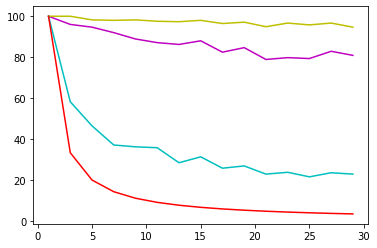

In [27]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 30, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(model, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(model, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()

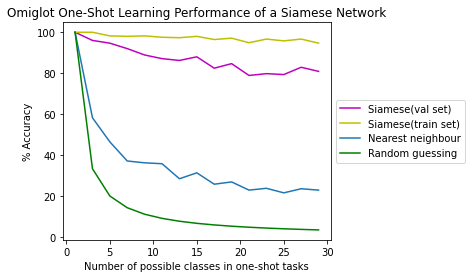

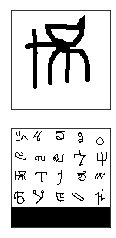

In [28]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20, "val")
plt.show()

plot_oneshot_task(inputs)